## Importación de Librerías ##

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, auc
import warnings
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('ignore')

In [26]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Muestra la información sobre los dispositivos disponibles
print(tf.config.list_physical_devices())

# Muestra el nombre de la GPU si está disponible
if tf.test.gpu_device_name():
    print(f"GPU encontrada: {tf.test.gpu_device_name()}")
else:
    print("No se encontró GPU. Asegúrate de que los controladores estén instalados correctamente.")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU encontrada: /device:GPU:0


# Lectura de los datos y solución de valores nulos #

In [27]:
df = pd.read_csv('files/weatherAUS.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145407  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145408  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145409  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145410  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145411  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
0            NaN           W           44.0          W  ...        22.0   
1            NaN         WNW           44.0        NNW  ...        25.0   
2            NaN         WSW           46.0          W  ...        30.0   
3            NaN          NE           24.0         SE  ...        16.0   
4            NaN           W           41.0        ENE  ...        33.0   
...          ...         ...            ...        ...  ...         ...   
145407       NaN           E           31.0        ESE  ...        27.0   
145408       NaN           E           31.0         SE  ...        24.0   
145409       NaN         NNW           22.0         SE  ...        21.0   
145410       NaN           N           37.0         SE  ...        24.0   
145411       NaN          SE           28.0        SSE  ...        24.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1       8.0       NaN     16.9     21.8   
1            1010.6       1007.8       NaN       NaN     17.2     24.3   
2            1007.6       1008.7       NaN       2.0     21.0     23.2   
3            1017.6       1012.8       NaN       NaN     18.1     26.5   
4            1010.8       1006.0       7.0       8.0     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
145407       1024.7       1021.2       NaN       NaN      9.4     20.9   
145408       1024.6       1020.3       NaN       NaN     10.1     22.4   
145409       1023.5       1019.1       NaN       NaN     10.9     24.5   
145410       1021.0       1016.8       NaN       NaN     12.5     26.1   
145411       1019.4       1016.5       3.0       2.0     15.1     26.0   

        RainToday  RainTomorrow  RainfallTomorrow  
0              No            No               0.0  
1              No            No               0.0  
2              No            No               0.0  
3              No            No               1.0  
4              No            No               0.2  
...           ...           ...               ...  
145407         No            No               0.0  
145408         No            No               0.0  
145409         No            No               0.0  
145410         No            No               0.0  
145411         No            No               0.0  

[145412 rows x 24 columns]

In [28]:
vacios_original=df.isna().sum()
vacios_original

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

## Clustering ##

Para solventar el problema de los datos vacíos decimos agrupar las ciudades en distintos clusters y completar aquellos datos vacíos con datos del mismo cluster para la misma fecha.

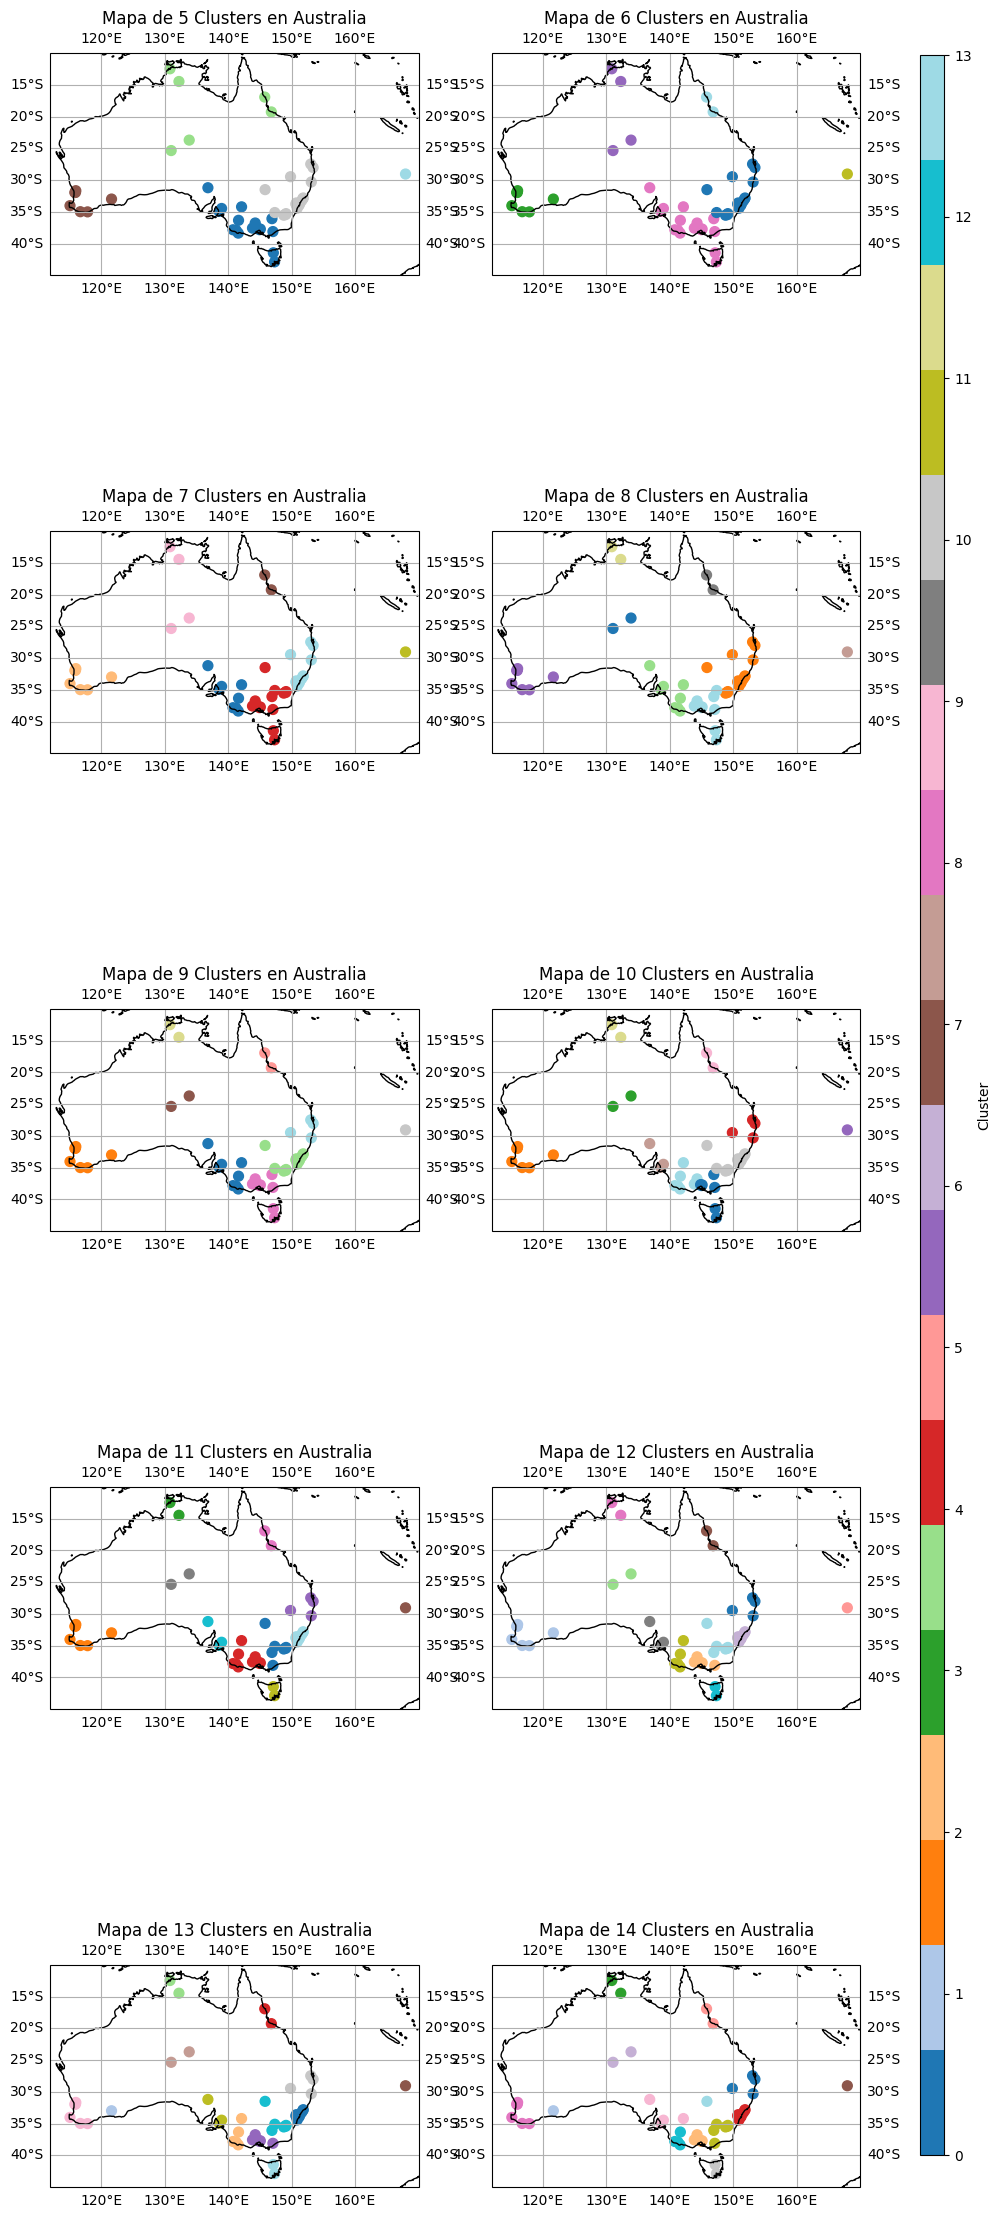

In [29]:
cities=df['Location'].unique().copy()
cities_coord = {'Adelaide': (-34.9285, 138.6007),
                'Albany': (-35.0031, 117.8657),
                'Albury': (-36.0737, 146.9135),
                'AliceSprings': (-23.6980, 133.8807),
                'BadgerysCreek': (-33.8813, 150.7400),
                'Ballarat': (-37.5622, 143.8503),
                'Bendigo': (-36.7570, 144.2794),
                'Brisbane': (-27.4698, 153.0251),
                'Cairns': (-16.9186, 145.7781),
                'Canberra': (-35.2809, 149.1300),
                'Cobar': (-31.4983, 145.8344),
                'CoffsHarbour': (-30.2963, 153.1131),
                'Dartmoor': (-37.9223, 141.2760),
                'Darwin': (-12.4634, 130.8456),
                'GoldCoast': (-28.0167, 153.4000),
                'Hobart': (-42.8821, 147.3272),
                'Katherine': (-14.4644, 132.2630),
                'Launceston': (-41.4545, 147.1317),
                'Melbourne': (-37.8136, 144.9631),
                'MelbourneAirport': (-37.6690, 144.8410),
                'Mildura': (-34.2083, 142.1270),
                'Moree': (-29.4638, 149.8413),
                'MountGambier': (-37.8241, 140.7798),
                'MountGinini': (-35.5294, 148.7720),
                'Newcastle': (-32.9283, 151.7817),
                'Nhil': (-36.3328, 141.6503),
                'NorahHead': (-33.2833, 151.5667),
                'NorfolkIsland': (-29.0408, 167.9547),
                'Nuriootpa': (-34.4667, 138.9833),
                'PearceRAAF': (-31.6675, 116.0158),
                'Penrith': (-33.7581, 150.6950),
                'Perth': (-31.9522, 115.8589),
                'PerthAirport': (-31.9405, 115.9660),
                'Portland': (-38.3511, 141.6056),
                'Richmond': (-33.6000, 150.7500),
                'Sale': (-38.1063, 147.0674),
                'SalmonGums': (-32.9819, 121.6431),
                'Sydney': (-33.8688, 151.2093),
                'SydneyAirport': (-33.9461, 151.1772),
                'Townsville': (-19.2583, 146.8169),
                'Tuggeranong': (-35.4244, 149.0887),
                'Uluru': (-25.3444, 131.0369),
                'WaggaWagga': (-35.1082, 147.3598),
                'Walpole': (-34.9772, 116.7317),
                'Watsonia': (-37.7114, 145.0831),
                'Williamtown': (-32.8150, 151.8428),
                'Witchcliffe': (-34.0264, 115.1000),
                'Wollongong': (-34.4241, 150.8931),
                'Woomera': (-31.1997, 136.8256)}

cities_coord = pd.DataFrame.from_dict(cities_coord, orient='index', columns=['lat', 'lon'])
cities_coord['mean_rain'] = df.groupby('Location')['Rainfall'].mean()
xPos=cities_coord[['lat','lon','mean_rain']].copy()
Nc= range(1, 20)
kmeans= [KMeans(n_clusters=i, n_init=10) for i in Nc]
score = [kmeans[i].fit(xPos).score(xPos) for i in range(len(kmeans))]
# plt.plot(Nc,score)
# plt.xlabel('NumberofClusters')
# plt.ylabel('Score')
# plt.title('ElbowCurve')
# plt.show()

num_clusters = range(5, 15)
num_rows = len(num_clusters) // 2 + len(num_clusters) % 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows), subplot_kw={'projection': ccrs.PlateCarree()})

for i, num_cluster in enumerate(num_clusters):
    # Elegir el número óptimo de clusters
    kmeans = KMeans(n_clusters=num_cluster, n_init=10).fit(xPos[['lon', 'lat']])
    centroids = kmeans.cluster_centers_

    # Asignar cada punto a su respectivo cluster
    xPos['cluster'] = kmeans.predict(xPos[['lon', 'lat']])
    labels = np.unique(xPos['cluster'])
    palette = sns.color_palette("tab20", len(labels))
    xPos['cluster'] = xPos['cluster'].astype('category')

    # Calcular la fila y la columna actual
    row = i // 2
    col = i % 2

    # Crear un mapa de Australia para el subplot actual
    ax = axes[row, col]
    ax.set_extent([112, 170, -45, -10], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Crear un gráfico de dispersión centrado en Australia
    scatter = ax.scatter(
        xPos['lon'], xPos['lat'],
        c=xPos['cluster'], cmap='tab20', s=50,
        transform=ccrs.PlateCarree()
    )

    # Configurar título y leyenda para el subplot
    ax.set_title(f'Mapa de {num_cluster} Clusters en Australia')

# Eliminar subplots vacíos si es necesario
if len(num_clusters) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

# Añadir una barra de color común para todos los subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=labels, label='Cluster')

plt.show()

Decidimos utilizar 13 clusters debido a que consideramos es la cantidad que mejor se ajusta a los datos sin hacer overfitting.

In [30]:
# Elegir el número óptimo de clusters
kmeans = KMeans(n_clusters=13, n_init=10).fit(xPos)
centroids = kmeans.cluster_centers_

# Asignar cada punto a su respectivo cluster
xPos['cluster'] = kmeans.predict(xPos)
labels = np.unique(xPos['cluster'])
palette = sns.color_palette("hot", len(labels))
xPos['cluster'] = xPos['cluster'].astype('category')

df['Cluster']=df['Location'].map(xPos['cluster'])
df.to_csv('files/weatherAUS_cluster.csv', index=False)

## Corrigiendo datos vacíos ##

Dado que estamos hablando de variables climáticas y se puede considerar que estan no presentan grandes variaciones para regiones cercanas, al clusterizar las ciudades podemos estimar aquellos datos vacíos como la media de los datos de las ciudades del mismo cluster para la misma fecha.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Date              145412 non-null  object  
 1   Location          145412 non-null  object  
 2   MinTemp           143928 non-null  float64 
 3   MaxTemp           144159 non-null  float64 
 4   Rainfall          142152 non-null  float64 
 5   Evaporation       82658 non-null   float64 
 6   Sunshine          75616 non-null   float64 
 7   WindGustDir       135096 non-null  object  
 8   WindGustSpeed     135159 non-null  float64 
 9   WindDir9am        134850 non-null  object  
 10  WindDir3pm        141186 non-null  object  
 11  WindSpeed9am      143645 non-null  float64 
 12  WindSpeed3pm      142351 non-null  float64 
 13  Humidity9am       142759 non-null  float64 
 14  Humidity3pm       140907 non-null  float64 
 15  Pressure9am       130351 non-null  float64 
 16  Pr

In [32]:
numeric_columns = df.select_dtypes(include=[float, int]).columns
non_numeric_columns = df.select_dtypes(include=[object]).columns

In [33]:
numeric_columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow'],
      dtype='object')

In [34]:
df['Date'] = pd.to_datetime(df['Date'])

# Agrupa por 'Cluster' y 'Date' y llena los valores nulos con la media del grupo.
grouped = df.groupby(['Cluster', 'Date'])
df_filled = grouped[numeric_columns].transform(lambda x: x.fillna(x.mean()))

df[numeric_columns] = df_filled

# Función para llenar los valores nulos con la moda
def fill_with_mode(x):
    mode_value = x.mode()
    if len(mode_value) > 0:
        return x.fillna(mode_value.iloc[0])
    else:
        return x

# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la moda del grupo
df_non_numeric = df.groupby(['Cluster', 'Date'])[non_numeric_columns].transform(fill_with_mode)

# Asignar los valores llenos al DataFrame original
df[non_numeric_columns] = df_non_numeric

In [35]:
vacios_transformado=df.isna().sum()
comparison_df = pd.DataFrame({'vacios_antes': vacios_original, 'vacios_despues': vacios_transformado})
total_datos = len(df)
comparison_df['porcentaje recuperado'] = 100 * (1 - comparison_df['vacios_despues'] / comparison_df['vacios_antes'])
comparison_df['porcentaje recuperado'] = comparison_df['porcentaje recuperado'].apply(lambda x: f'{x:.2f}%')
comparison_df['porcentaje_completo'] = 100 * (1 - comparison_df['vacios_despues'] / total_datos)
comparison_df['porcentaje_completo'] = comparison_df['porcentaje_completo'].apply(lambda x: f'{x:.2f}%')


# Mostrar el DataFrame con la comparación
comparison_df

vacios_antes  vacios_despues porcentaje recuperado  \
Cloud3pm               59336.0            7259                87.77%   
Cloud9am               55870.0            6845                87.75%   
Cluster                    NaN               0                  nan%   
Date                       0.0               0                  nan%   
Evaporation            62754.0            6298                89.96%   
Humidity3pm             4505.0              45                99.00%   
Humidity9am             2653.0              45                98.30%   
Location                   0.0               0                  nan%   
MaxTemp                 1253.0              44                96.49%   
MinTemp                 1484.0              44                97.04%   
Pressure3pm            15024.0            3006                79.99%   
Pressure9am            15061.0            3011                80.01%   
RainToday               3260.0             112                96.56%   
RainTomorrow            3259.0             112                96.56%   
Rainfall                3260.0             112                96.56%   
RainfallTomorrow        3259.0             112                96.56%   
Sunshine               69796.0           10199                85.39%   
Temp3pm                 3607.0              42                98.84%   
Temp9am                 1766.0              42                97.62%   
WindDir3pm              4226.0              93                97.80%   
WindDir9am             10562.0             366                96.53%   
WindGustDir            10316.0             512                95.04%   
WindGustSpeed          10253.0             510                95.03%   
WindSpeed3pm            3061.0              79                97.42%   
WindSpeed9am            1767.0              89                94.96%   

                 porcentaje_completo  
Cloud3pm                      95.01%  
Cloud9am                      95.29%  
Cluster                      100.00%  
Date                         100.00%  
Evaporation                   95.67%  
Humidity3pm                   99.97%  
Humidity9am                   99.97%  
Location                     100.00%  
MaxTemp                       99.97%  
MinTemp                       99.97%  
Pressure3pm                   97.93%  
Pressure9am                   97.93%  
RainToday                     99.92%  
RainTomorrow                  99.92%  
Rainfall                      99.92%  
RainfallTomorrow              99.92%  
Sunshine                      92.99%  
Temp3pm                       99.97%  
Temp9am                       99.97%  
WindDir3pm                    99.94%  
WindDir9am                    99.75%  
WindGustDir                   99.65%  
WindGustSpeed                 99.65%  
WindSpeed3pm                  99.95%  
WindSpeed9am                  99.94%

Podemos notar que el método fue efectivo, habiendo recuperado grandes cantidades de datos y con registros totales completos que se acercan al 100%. Ahora podríamos considerar eliminar los registros que presenten valores nulos y no deberíamos perder grandes vólumenes de información.

In [36]:
df_sin_nan = df.dropna()
df_sin_nan.to_csv('files/weatherAUS_sin_nan.csv', index=False)
df=df_sin_nan.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131279 entries, 0 to 144987
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              131279 non-null  datetime64[ns]
 1   Location          131279 non-null  object        
 2   MinTemp           131279 non-null  float64       
 3   MaxTemp           131279 non-null  float64       
 4   Rainfall          131279 non-null  float64       
 5   Evaporation       131279 non-null  float64       
 6   Sunshine          131279 non-null  float64       
 7   WindGustDir       131279 non-null  object        
 8   WindGustSpeed     131279 non-null  float64       
 9   WindDir9am        131279 non-null  object        
 10  WindDir3pm        131279 non-null  object        
 11  WindSpeed9am      131279 non-null  float64       
 12  WindSpeed3pm      131279 non-null  float64       
 13  Humidity9am       131279 non-null  float64       
 14  Humidity3

## Unificando Variables relacionadas ##

Existen relaciones intrínsecas entre ciertas variables, para poder hacer predicciones con ellas decidimos unificarlas en otras nuevas. Construimos un vector para aquellas variables que presentaban módulo y dirección, para luego tomar sus componentes como nuevos parámetros. Tomamos la diferencia de presiones también como nueva variable, el mismo procedimiento lo hacemos para la humedad. Para las variables de nubosidad construimos una nueva variable categórica que representara el estado del cielo en ese día.

In [37]:
def vector_coordinates(df, column, dir, speed, threshold=1e-6):
    direcciones = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }
    velocidad = df[speed]
    df[column + 'u'] = -velocidad * np.sin(np.deg2rad(df[dir].map(direcciones)))
    df[column + 'v'] = -velocidad * np.cos(np.deg2rad(df[dir].map(direcciones)))
    
    # Comprobación condicional para valores cercanos a cero
    df[column + 'u'][np.abs(df[column + 'u']) < threshold] = 0
    df[column + 'v'][np.abs(df[column + 'v']) < threshold] = 0
    
    return df

def definir_estado_del_cielo(row):
    if row['Cloud9am'] == 0 and row['Cloud3pm'] == 0:
        return 'Despejado'
    elif row['Cloud9am'] <= 4 and row['Cloud3pm'] <= 4:
        return 'Parcialmente Nublado'
    elif row['Cloud9am'] <= 7 and row['Cloud3pm'] <= 7:
        return 'Nublado'
    else:
        return 'Muy Nublado'

In [38]:
df=vector_coordinates(df,'Wind9am','WindDir9am','WindSpeed9am')
df=vector_coordinates(df,'Wind3pm','WindDir3pm','WindSpeed3pm')
df=vector_coordinates(df,'WindGust','WindGustDir','WindGustSpeed')
df['Pressure_Difference'] = df['Pressure3pm'] - df['Pressure9am']
df['Humidity_Difference'] = df['Humidity3pm'] - df['Humidity9am']
df['Estado_Cielo'] = df.apply(definir_estado_del_cielo, axis=1)
df.drop(['Cloud3pm','Cloud9am','Humidity3pm','Humidity9am','WindSpeed9am','WindSpeed3pm','WindGustSpeed','WindDir9am','WindDir3pm','WindGustDir','Pressure3pm','Pressure9am','Temp3pm','Temp9am'], axis=1, inplace=True)


# Visualización y análisis de datos #

In [39]:
def city_dataframe(df,city):
    df_city = df[df['Location'] == city]
    return df_city

def cluster_dataframe(df,cluster):
    df_cluster = df[df['Cluster'] == cluster]
    return df_cluster

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 50))
    plt.show()

def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_rows, 20 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=30)
        axs[row, col_idx].set_ylabel("Count",fontsize=20)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=20)
        axs[row, col_idx].tick_params(axis='y', labelsize=20)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Histogramas de variales numéricas", fontsize=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def matriz_correlacion(df):
    corr = df.select_dtypes(include=[float, int]).corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 15))

    ax = sns.heatmap(
        corr,
        #mask = mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        annot_kws={'size': 15},
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación: {df['Location'].iloc[0]}", fontsize=30)
    else:
        ax.set_title("Matriz de Correlación", fontsize=30)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def global_boxplots(df):
    # Asegúrate de que todas las columnas sean numéricas
    columnas_numericas = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()

def date_boxplots(df, year, month):
    # Asegúrate de que la columna 'Date' sea de tipo datetime
    df1 = df.drop(['Rainfall','RainfallTomorrow'],axis=1).copy()  # Realizar una copia del DataFrame para evitar el SettingWithCopyWarning

    # Filtrar el DataFrame por el año y el mes específicos
    filtered_df1 = df1[(df1['Date'].dt.year == year) & (df1['Date'].dt.month == month)]
    
    if filtered_df1.empty:
        print("No hay datos para el año y mes especificados.")
        return
    
    # Seleccionar solo las columnas numéricas
    columnas_numericas = filtered_df1.select_dtypes(include=['number'])
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Obtener la cantidad de datos disponibles
    cantidad_datos = len(filtered_df1)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title(f"Boxplots para {year}/{month}")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()


def scatter_plot(df):
    numeric_cols = df.drop(['RainfallTomorrow'], axis=1).select_dtypes(include=['number'])
    num_plots = len(numeric_cols.columns)
    
    # Determina el número de filas y columnas para la matriz
    num_rows = (num_plots + 2) // 3  # Redondea hacia arriba
    num_cols = min(num_plots, 3)

    # Aumenta el tamaño de la figura
    figsize = (20, num_rows * 6)  # Aumenta la altura de la figura
    
    # Crea una figura de Matplotlib con subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(numeric_cols.columns):
        row = i // num_cols
        col_num = i % num_cols  # Cambia el nombre de la variable para evitar la confusión

        # Selecciona el subplot actual
        ax = axes[row, col_num]

        # Crea el gráfico de dispersión en el subplot
        sns.scatterplot(x=col, y='RainfallTomorrow', data=df, hue='Cluster', ax=ax)
        ax.set_title(col)  # Configura el título del subplot

    # Elimina subplots no utilizados
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col_num = i % num_cols
        fig.delaxes(axes[row, col_num])

    plt.tight_layout()
    plt.show()
    
def graficos(df):
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {len(df)}")
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)
    scatter_plot(df)

Usamos la función gráfico para plotear distintos gráficos para el dataframe.

Cantidad de datos disponibles en el DataFrame: 131279


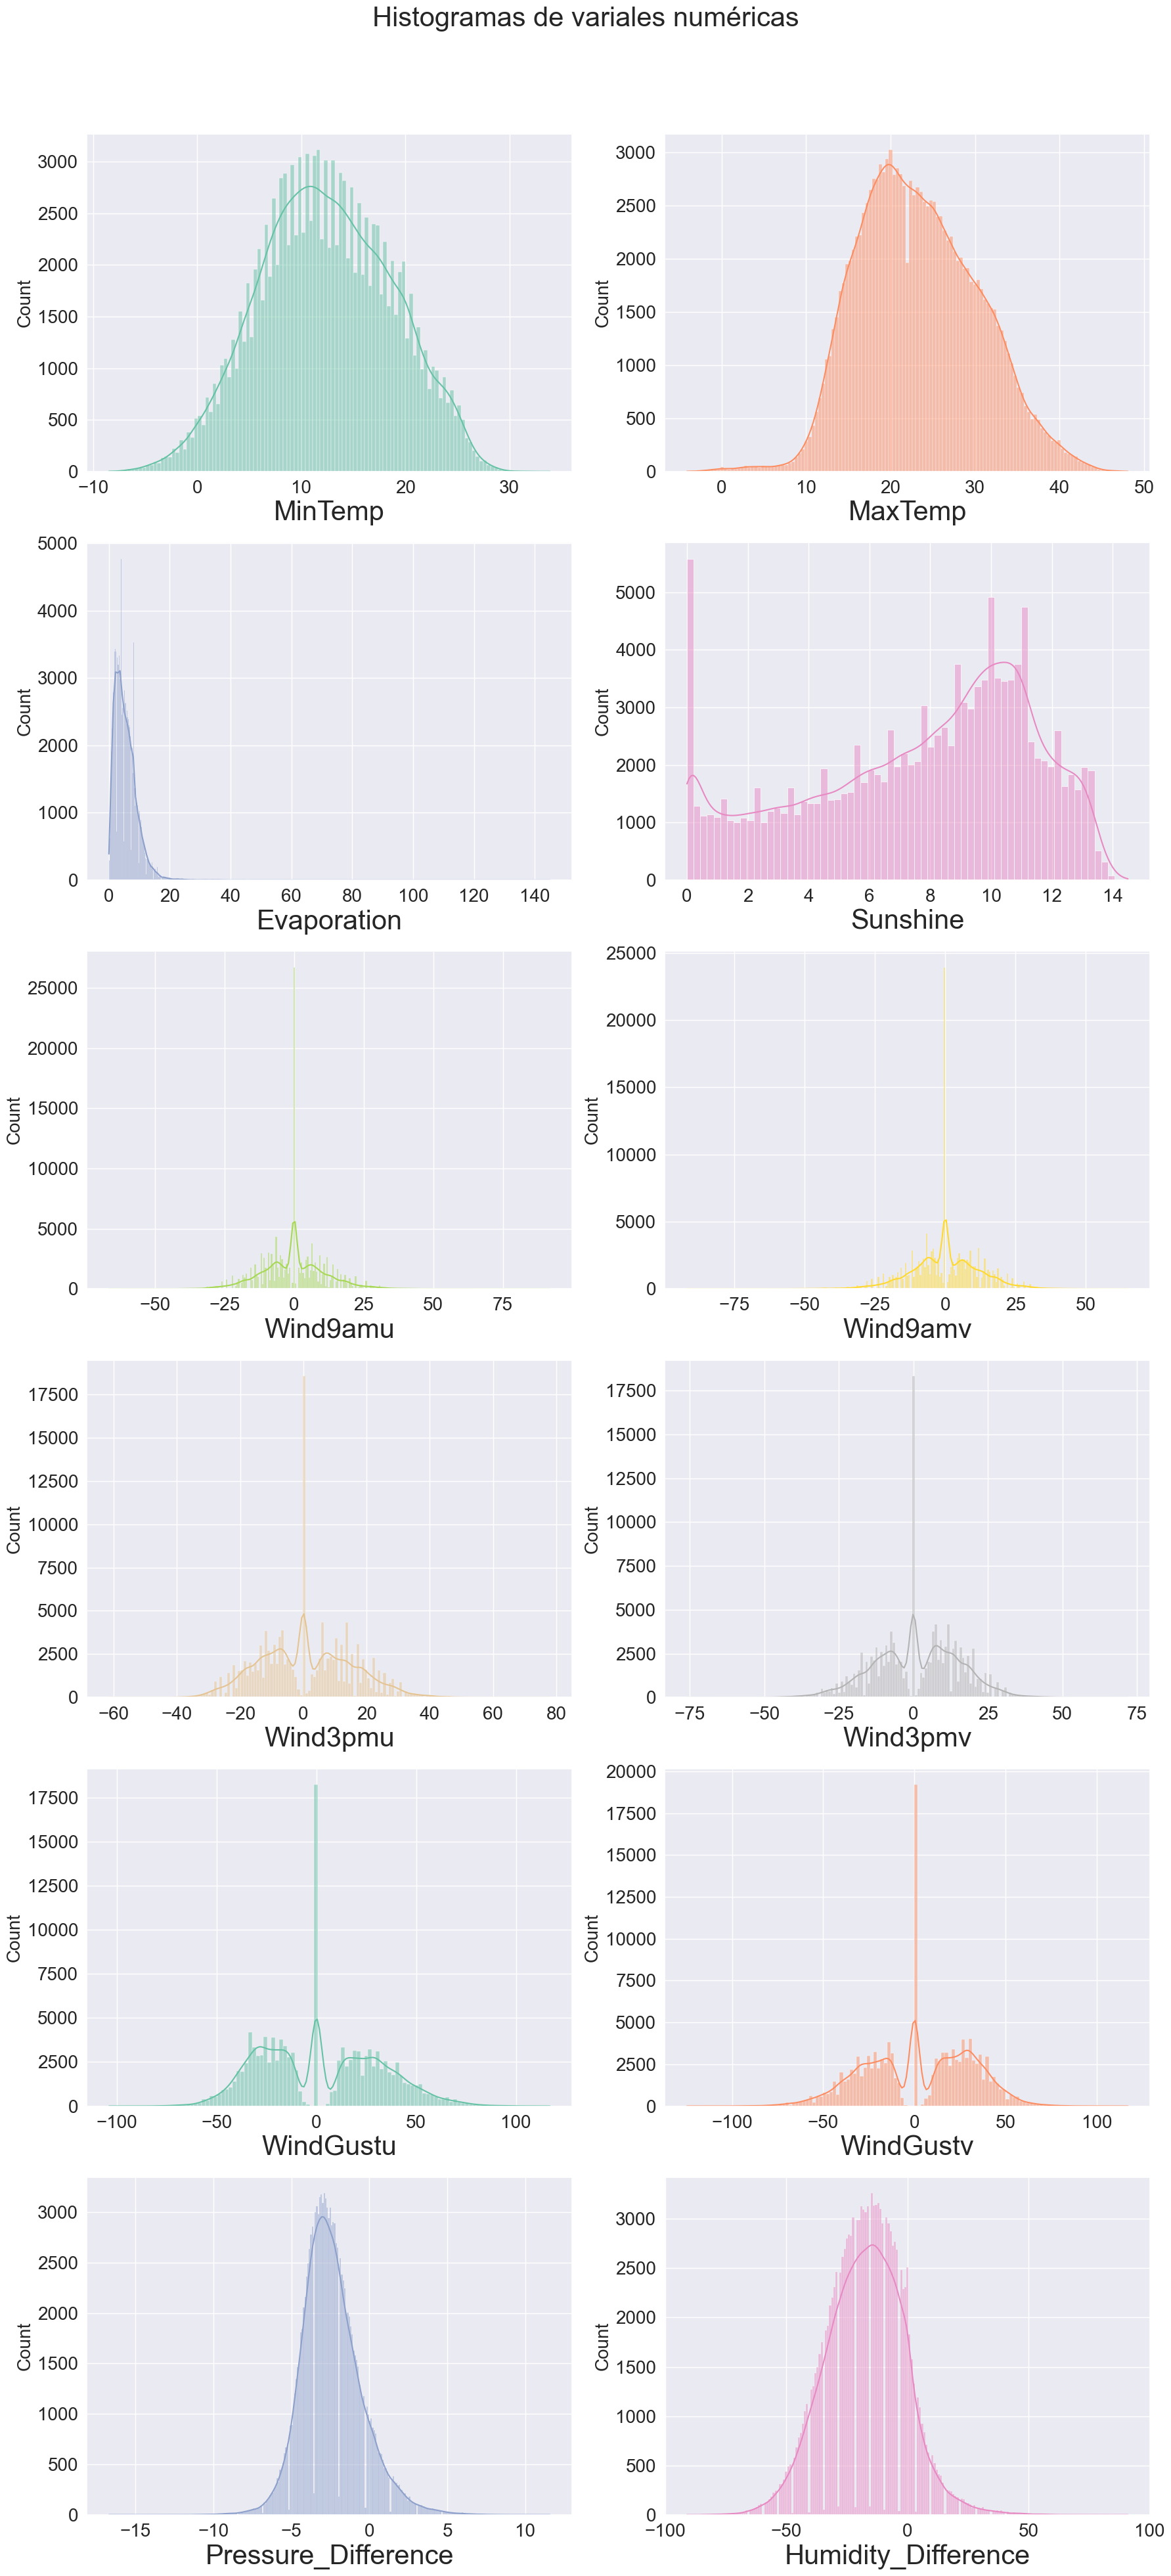

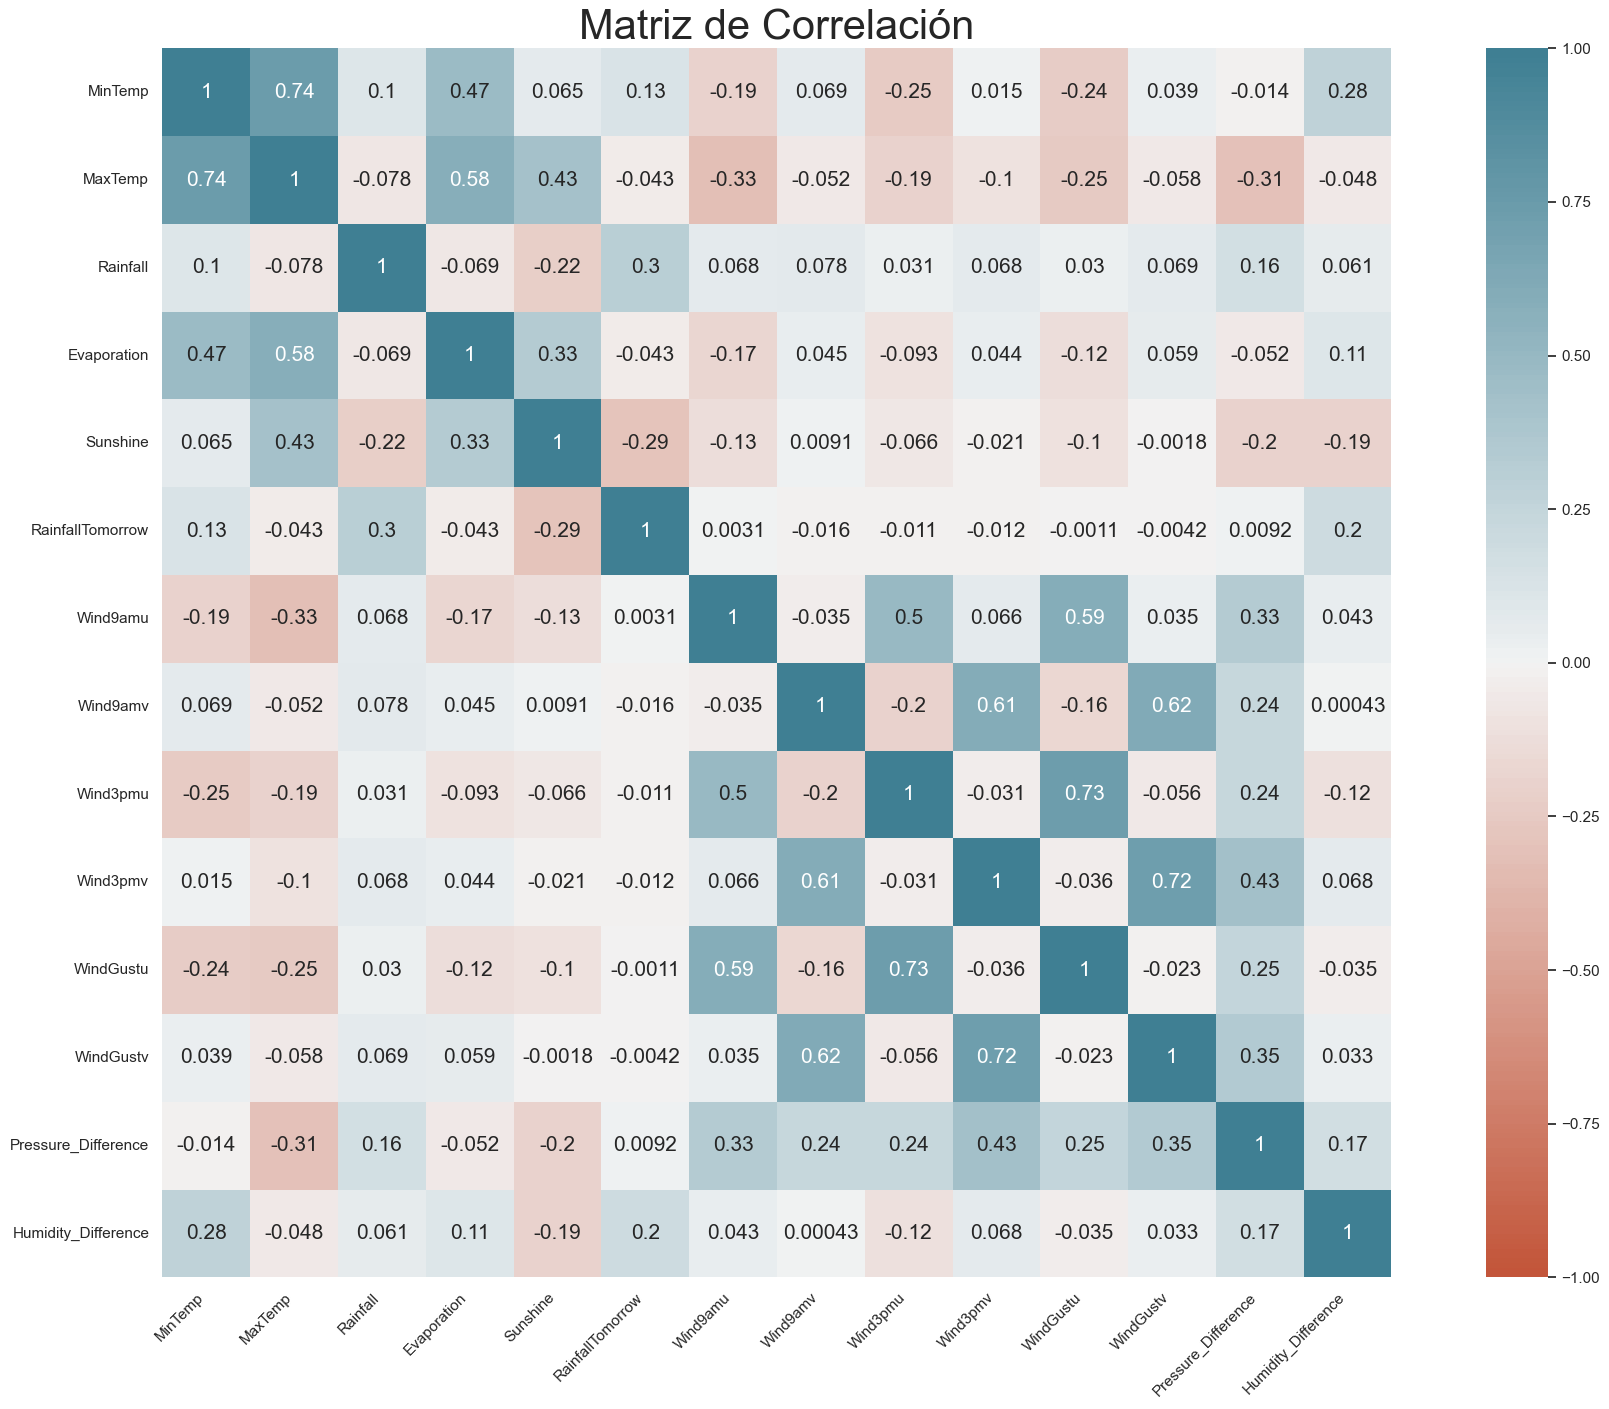

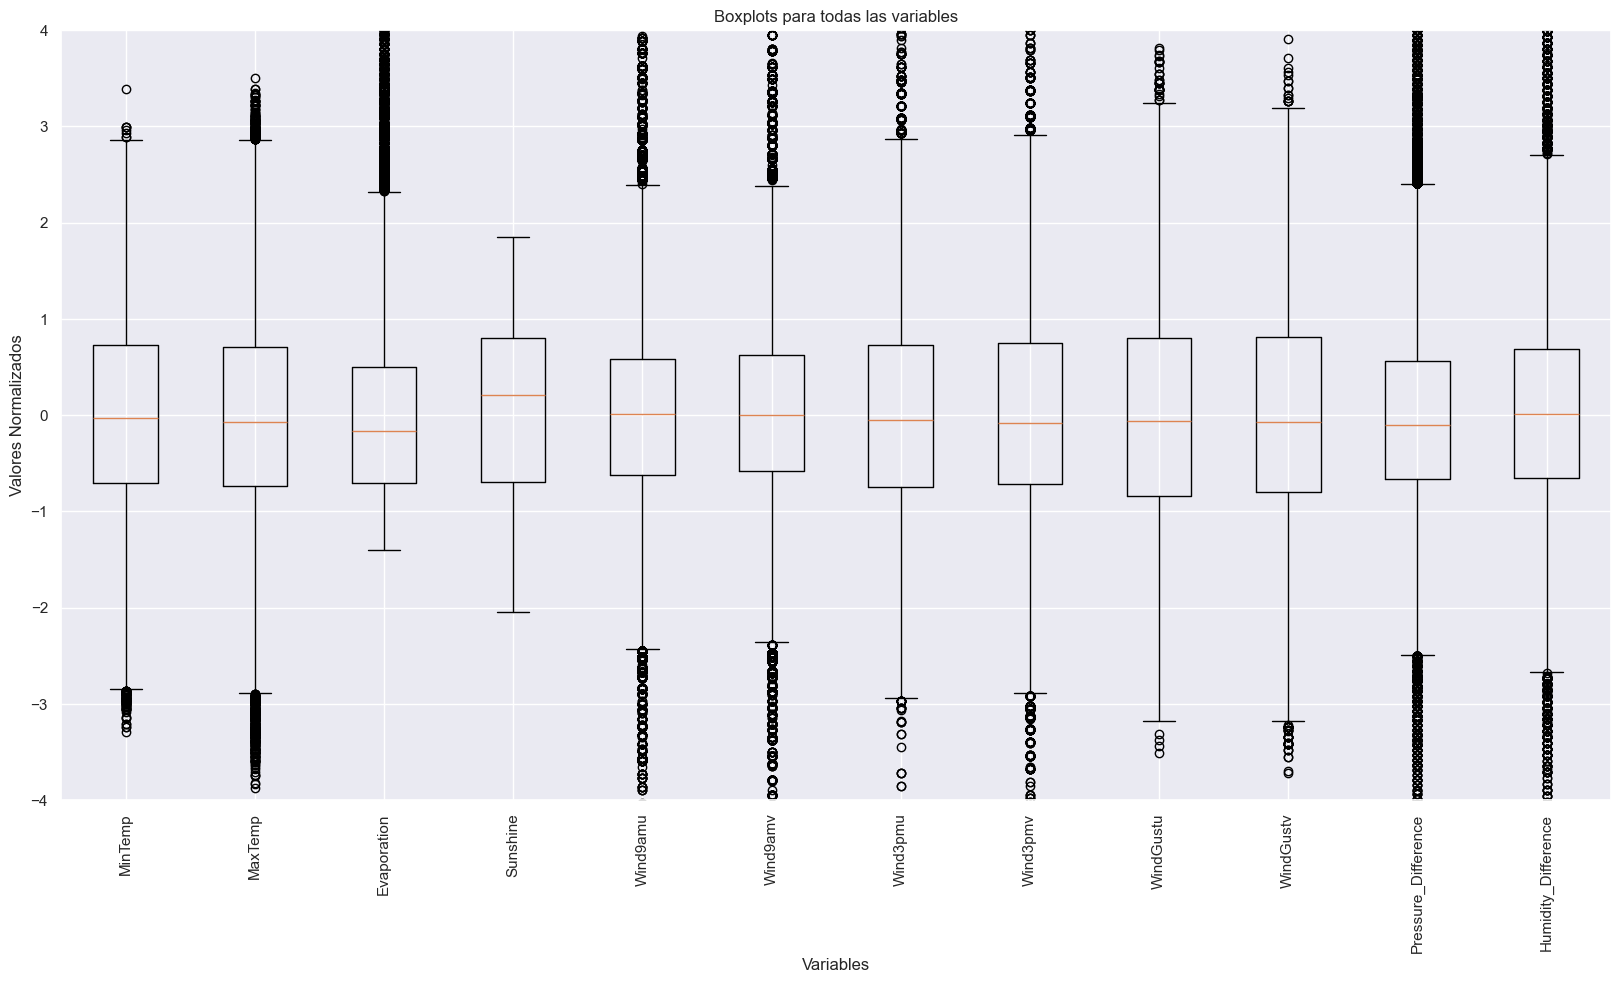

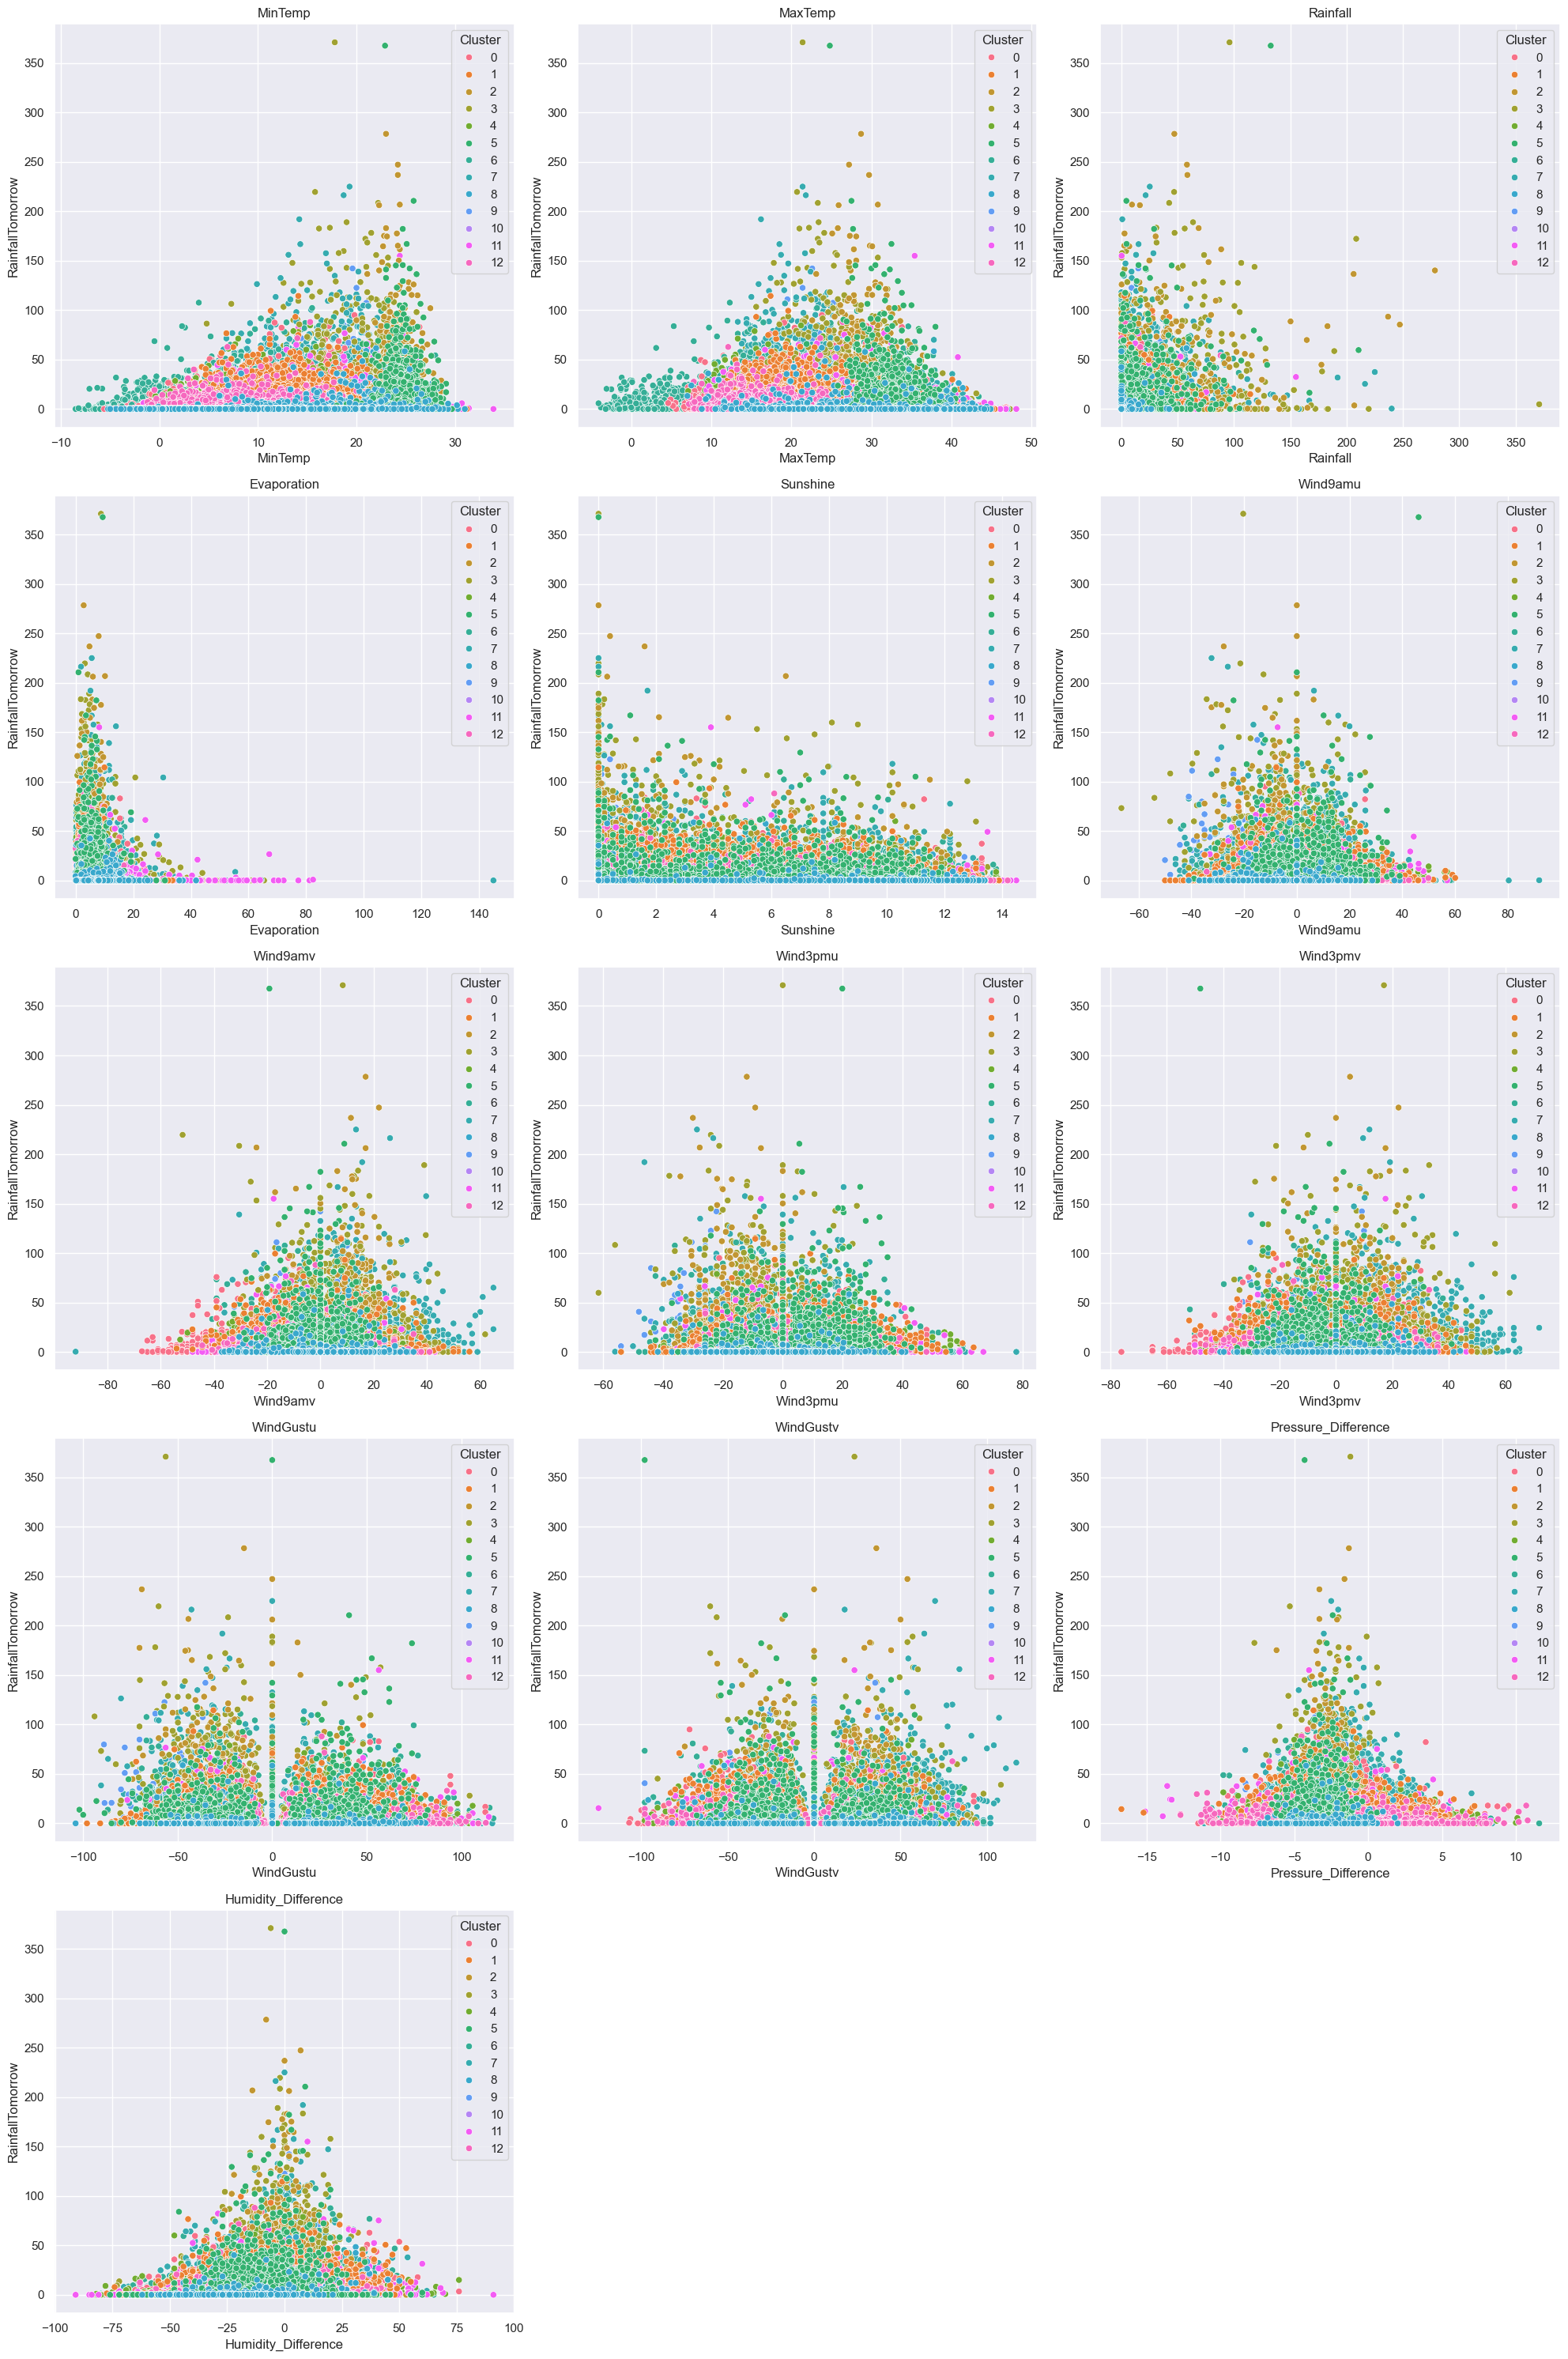

In [40]:
graficos(df)

Podemos usar la misma función para visualizar los datos de un cluster particular.

Cantidad de datos disponibles en el DataFrame: 18244


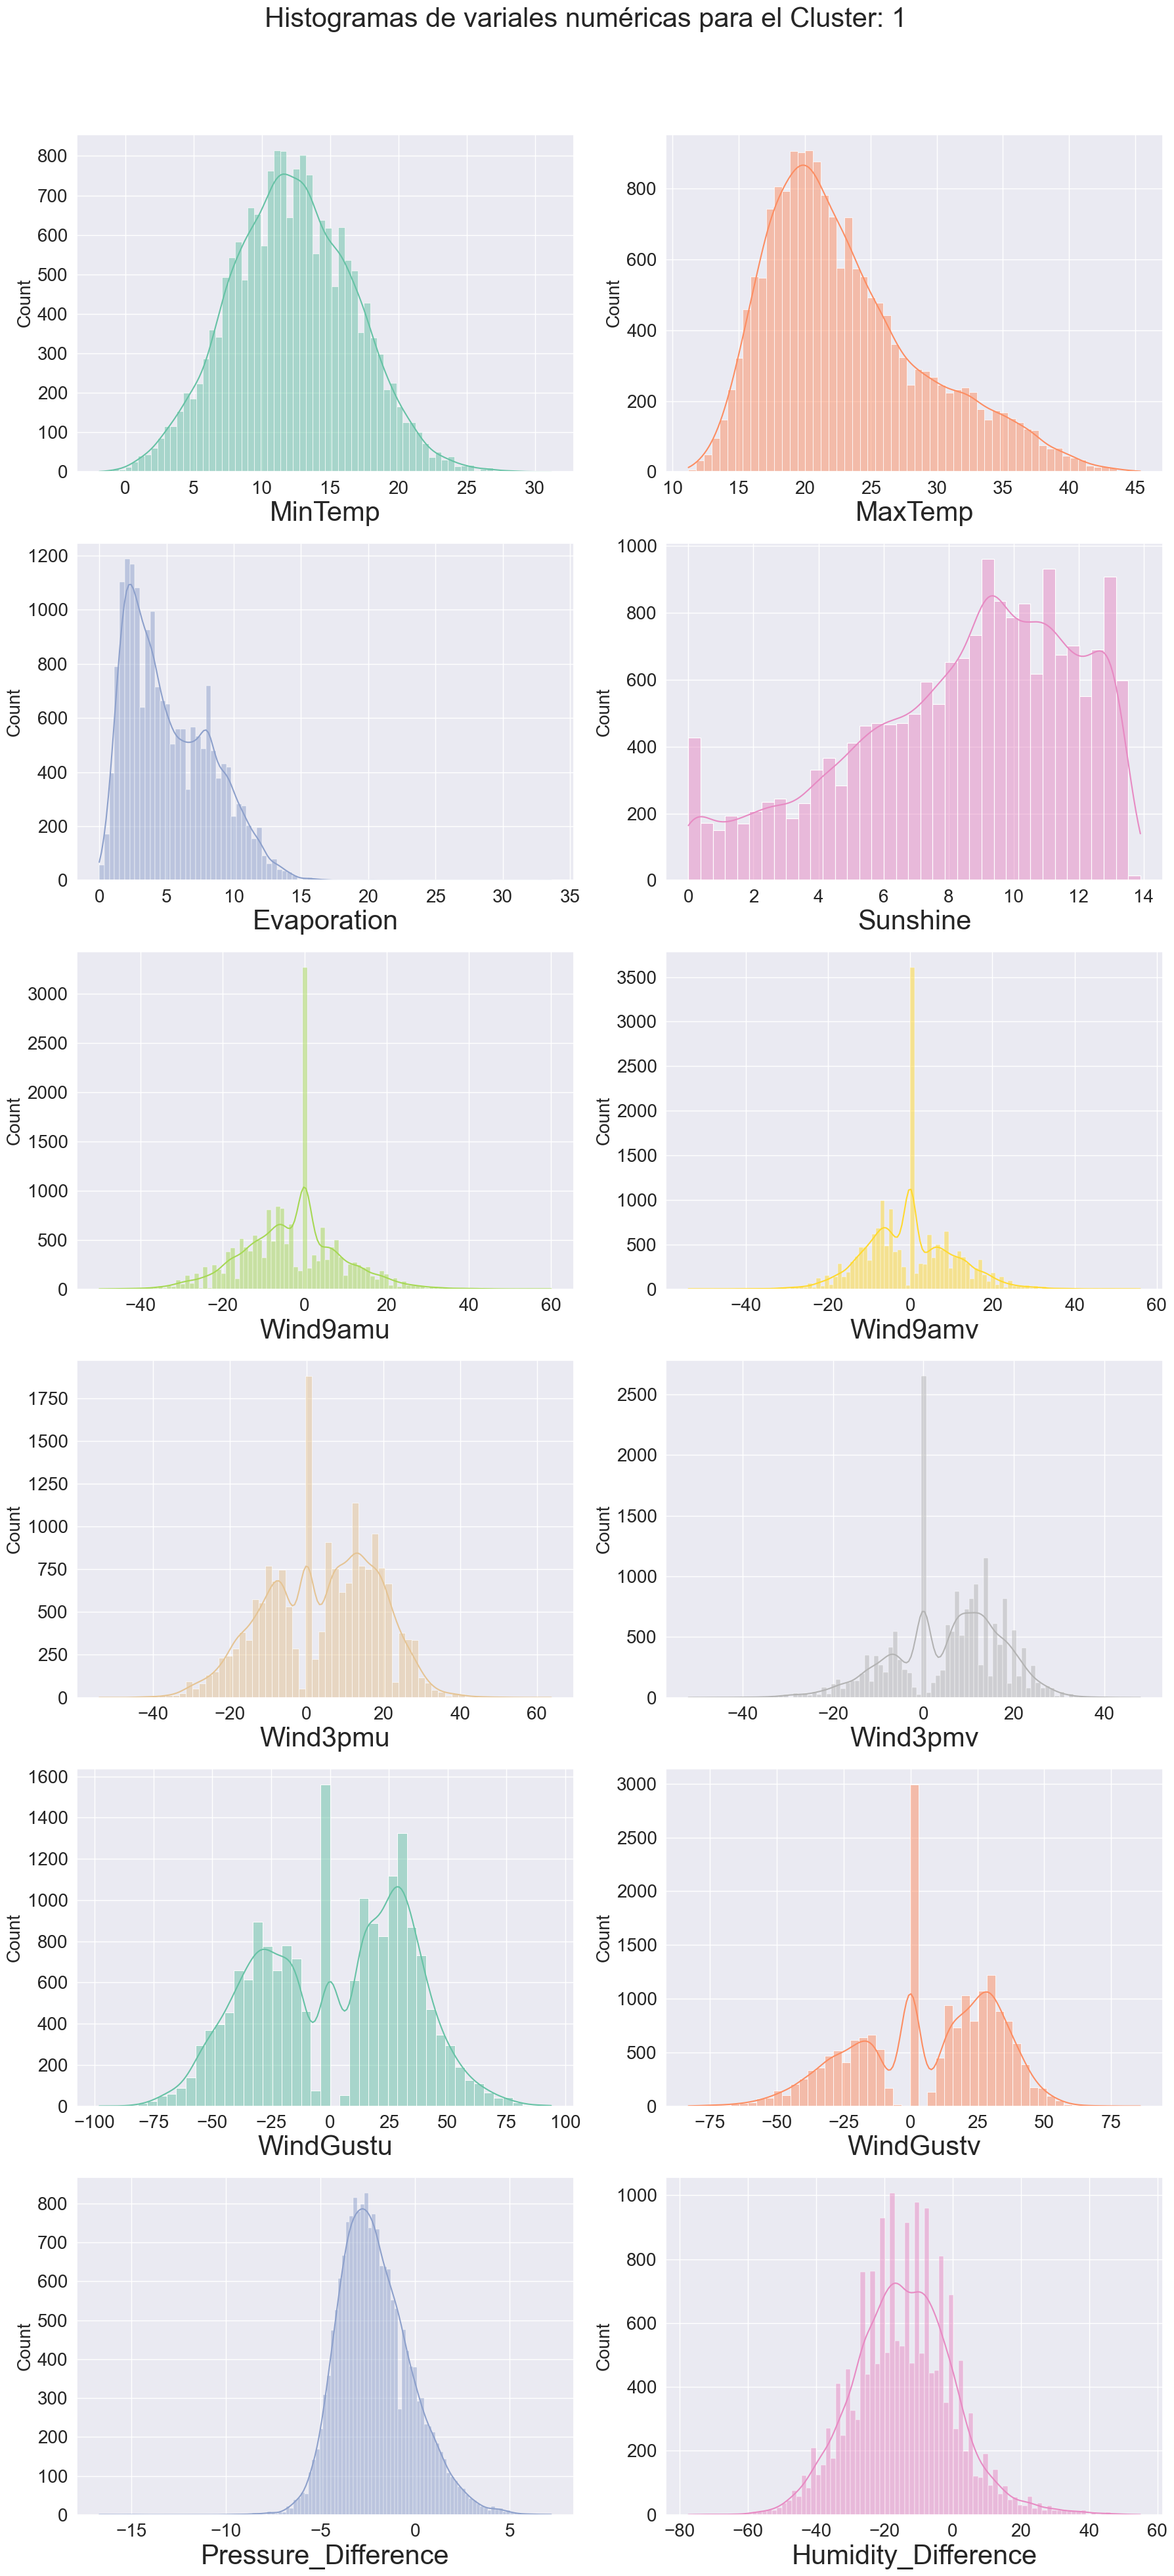

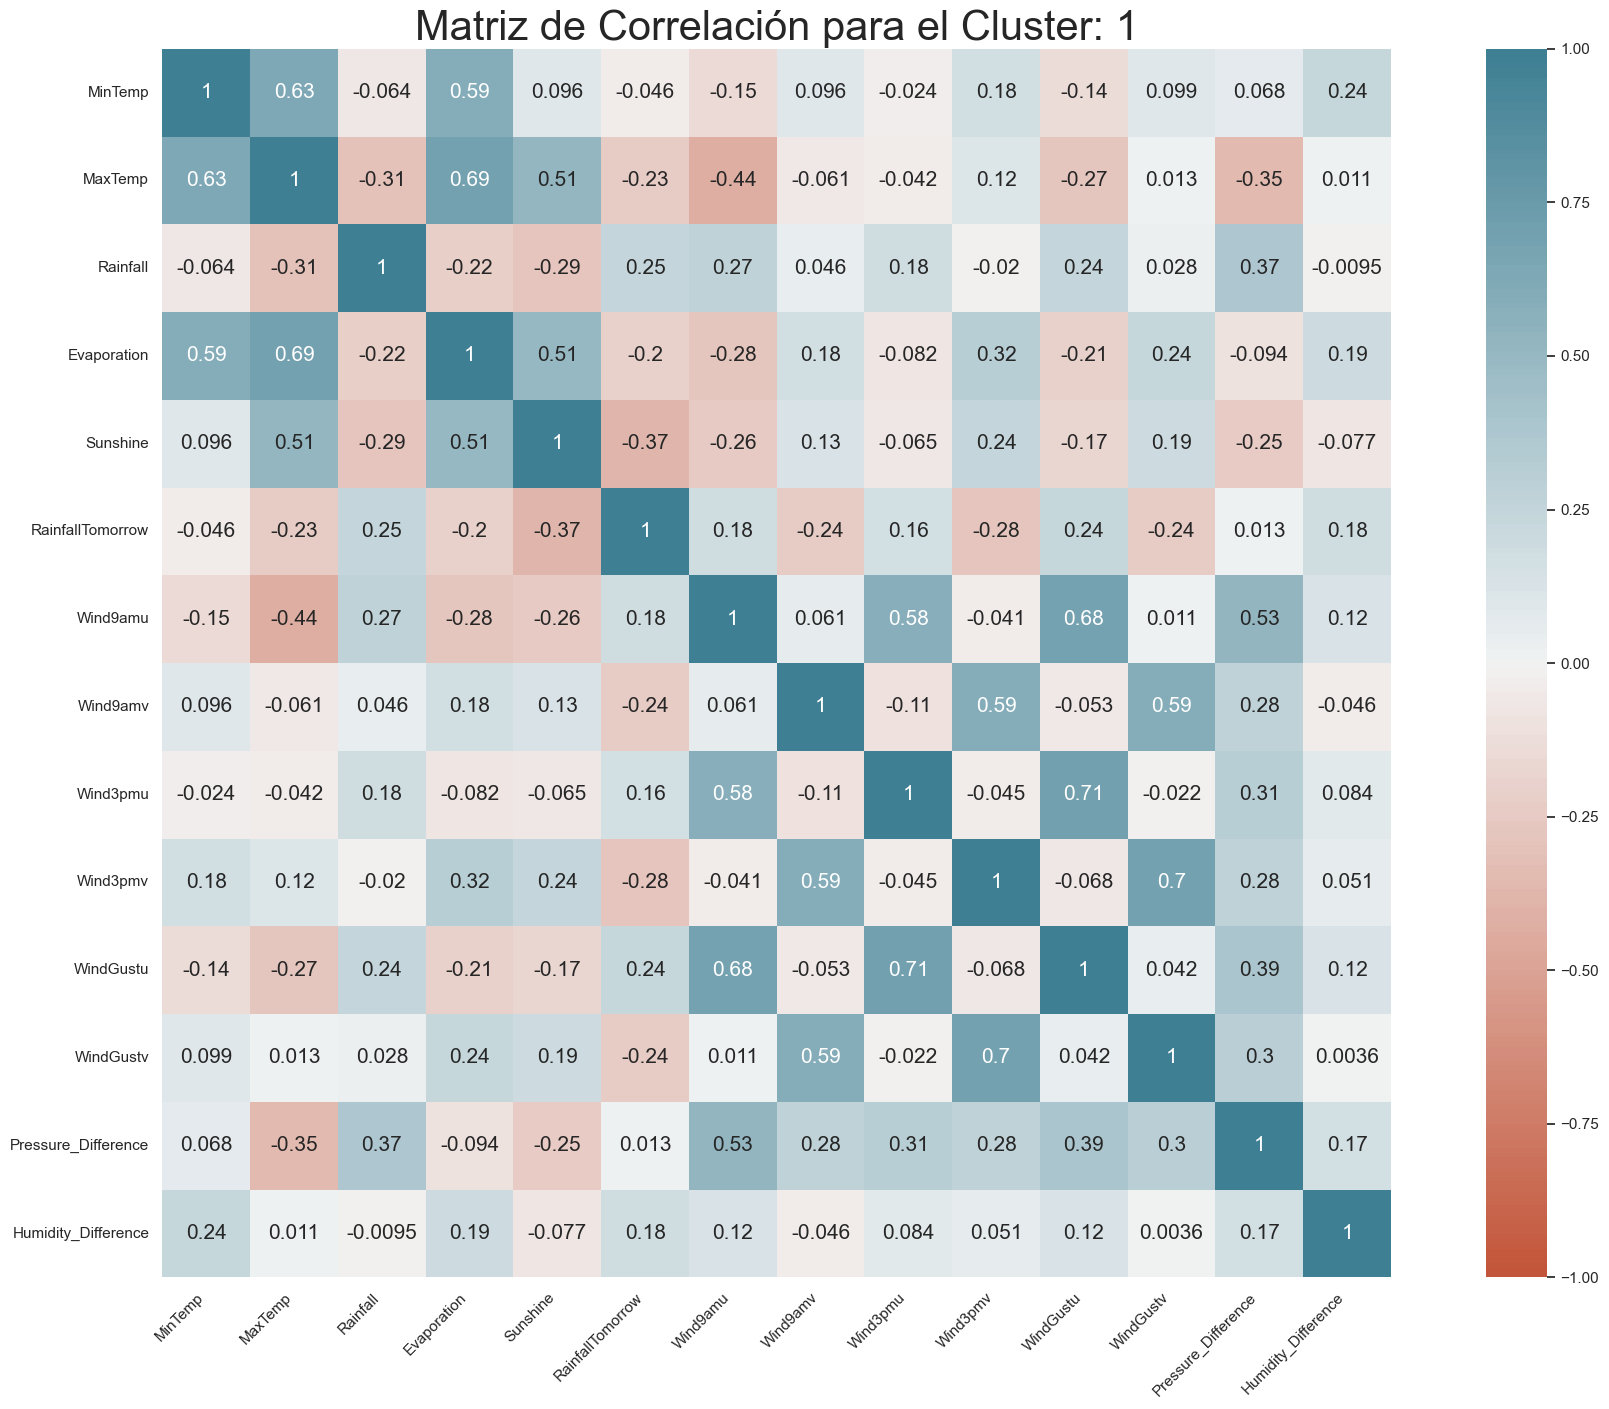

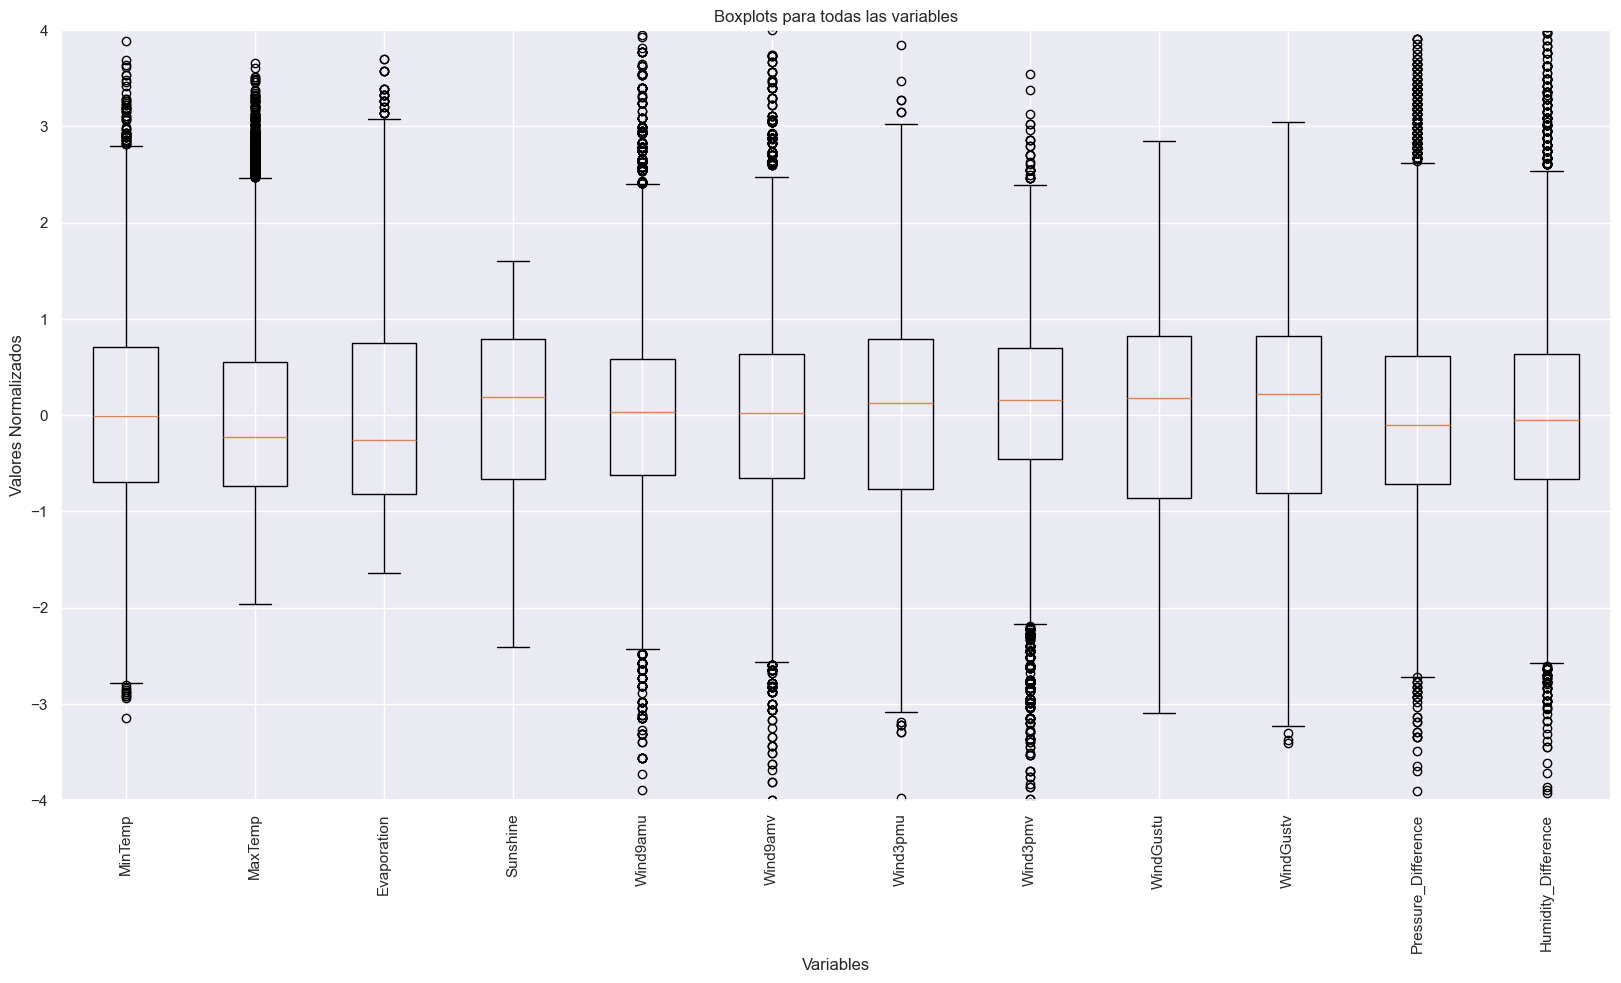

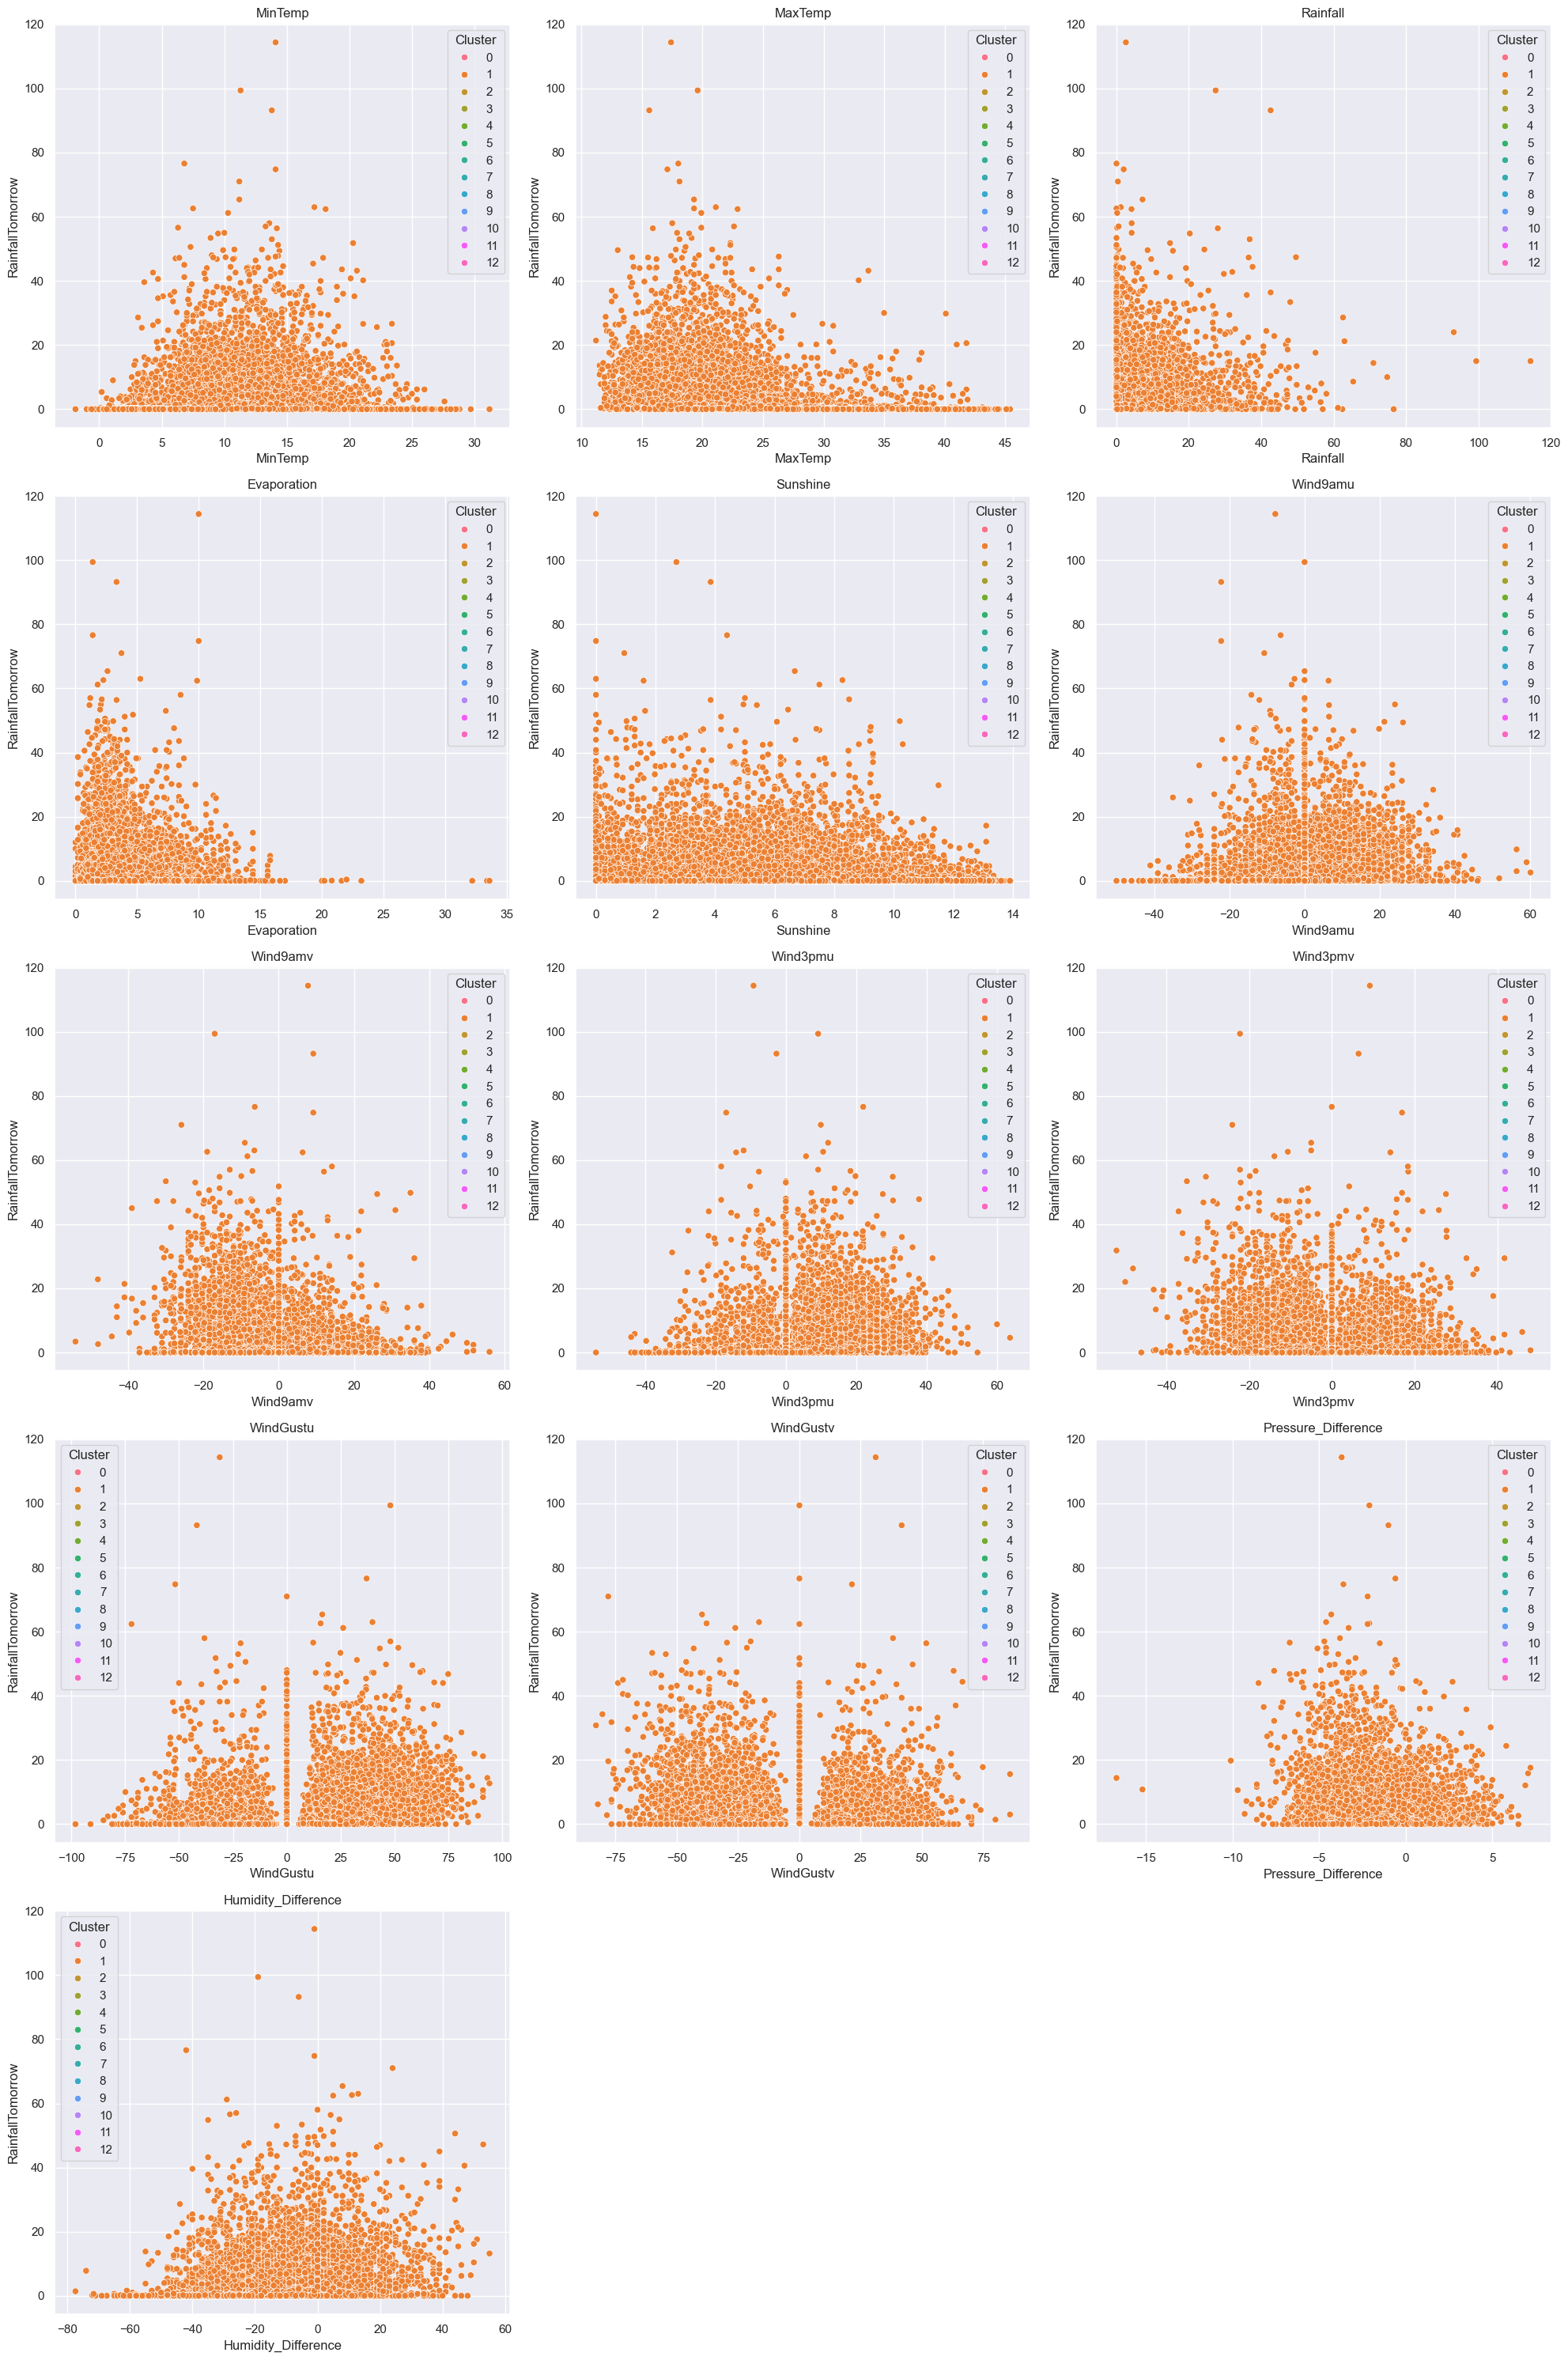

In [41]:
graficos(cluster_dataframe(df,1))

Y también tenemos un método que nos permite ver los boxplot para un mes particular, en caso de que sea necesario.

## Eliminación de Outliers ##
Diseñamos una función que recibe el dataframe y nos elimina del mismo aquellos registros que presentan outliers en alguna de las variables númericas teniendo en cuenta un threshold que puede ser modificado para hacerlo mas o menos restrictivo. En este caso tomamos un valor de 1.5 lo que significa que eliminaremos aquellos valores que esten a mas de 1.5 veces el rango intercuartilico.

In [42]:
def remove_outliers(df, threshold=1.5):
    cleaned_df = df.copy()
    columns = df.drop(['RainTomorrow','RainfallTomorrow','RainToday','Rainfall'],axis=1).select_dtypes(include=[float, int])
    for column in columns:
        if column in df.columns:
            # Calcular el rango intercuartílico (IQR)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Definir los límites para identificar valores atípicos
            lower_limit = Q1 - threshold * IQR
            upper_limit = Q3 + threshold * IQR

            # Eliminar valores atípicos
            cleaned_df = cleaned_df[(cleaned_df[column] >= lower_limit) & (cleaned_df[column] <= upper_limit)]

    return cleaned_df

cleaned_df = remove_outliers(df)
print("Cantidad de datos removidos:", len(df) - len(cleaned_df))
cleaned_df

Cantidad de datos removidos: 13150


Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          9.6      13.0   
1      2008-12-02   Albury      7.4     25.1       0.0         13.0      13.2   
2      2008-12-03   Albury     12.9     25.7       0.0         10.2      13.2   
3      2008-12-04   Albury      9.2     28.0       0.0         11.0      10.8   
4      2008-12-05   Albury     17.5     32.3       1.0          6.6       8.1   
...           ...      ...      ...      ...       ...          ...       ...   
144980 2016-04-19    Uluru     13.5     35.2       0.0          9.6      10.9   
144981 2016-04-20    Uluru     18.8     31.7       0.0          8.0       9.9   
144985 2016-04-24    Uluru     12.1     27.3       0.0          8.2      11.0   
144986 2016-04-25    Uluru      9.6     28.8       0.0          7.8      11.0   
144987 2016-04-26    Uluru     11.0     32.5       0.0          8.0      11.0   

       RainToday RainTomorrow  RainfallTomorrow Cluster   Wind9amu   Wind9amv  \
0             No           No               0.0       6  20.000000   0.000000   
1             No           No               0.0       6   1.530734  -3.695518   
2             No           No               0.0       6  19.000000   0.000000   
3             No           No               1.0       6  -7.778175   7.778175   
4             No           No               0.2       6  -6.467157  -2.678784   
...          ...          ...               ...     ...        ...        ...   
144980        No           No               0.0       8  -9.000000   0.000000   
144981        No           No               0.0       8   0.000000  17.000000   
144985        No           No               0.0       8 -20.325350  -8.419036   
144986        No           No               0.0       8 -13.000000   0.000000   
144987        No           No               0.0       8 -11.000000   0.000000   

         Wind3pmu   Wind3pmv  WindGustu  WindGustv  Pressure_Difference  \
0       22.173109  -9.184402  44.000000   0.000000                 -0.6   
1       20.325350   8.419036  40.650699 -16.838071                 -2.8   
2       24.020868   9.949769  42.498458  17.603438                  1.1   
3       -9.000000   0.000000 -16.970563 -16.970563                 -4.8   
4       14.142136 -14.142136  41.000000   0.000000                 -4.8   
...           ...        ...        ...        ...                  ...   
144980  11.000000   0.000000  28.640266  11.863186                 -3.1   
144981 -13.435029 -13.435029  11.863186  28.640266                 -2.8   
144985 -19.000000   0.000000 -31.000000   0.000000                 -4.8   
144986  -3.444151  -8.314916 -30.000000   0.000000                 -4.6   
144987  16.970563 -16.970563   0.000000 -33.000000                 -4.9   

        Humidity_Difference          Estado_Cielo  
0                     -49.0           Muy Nublado  
1                     -19.0  Parcialmente Nublado  
2                      -8.0  Parcialmente Nublado  
3                     -29.0               Nublado  
4                     -49.0           Muy Nublado  
...                     ...                   ...  
144980                -18.0  Parcialmente Nublado  
144981                -20.0           Muy Nublado  
144985                -21.0             Despejado  
144986                -15.0             Despejado  
144987                -16.0  Parcialmente Nublado  

[118129 rows x 20 columns]

## Análisis de Balance ##
Para analizar el balance necesitamos determinar si la distribución de las variables target, en este caso categóricas esta uniformemente distribuida. Para eso diseñamos el siguiente método. Pretendemos que los scores estén cerca de 0.5 lo que representaría una distribución uniforme de los datos.

In [43]:
def check_balance(df, target_columns):

    balance_scores = {}

    for column in target_columns:
        class_counts = df[column].value_counts()
        num_classes = len(class_counts)
        max_count = class_counts.max()
        balance_score = max_count / len(df)
        balance_scores[column] = balance_score

    return balance_scores

target_columns = ["RainTomorrow"]
balance_scores = check_balance(cleaned_df, target_columns)
print("Balance Scores:")
for column, score in balance_scores.items():
    print(f"{column}: {score}")

Balance Scores:
RainTomorrow: 0.7867924049132727


Dado que el valor de balance ronda el 0.8, el target RainTomorrow presentan una distribución no uniforme para sus respectivos valores. Esto quiere decir que el dataset no está balanceado.

## Selección de características y Estandarización ##

Para predecir la lluvia del día siguiente, decidimos trabajar con todas las variables (originales o transformadas) del dataset.

In [44]:
def dataframe_normalized(df,features):
    df_normalized = df.copy()
    skystate = {
        'Despejado' :               0,
        'Parcialmente Nublado' :    1,
        'Nublado' :                 2,
        'Muy Nublado' :             3
    }
    df_normalized['RainToday'] = df_normalized['RainToday'].map({'No': 0, 'Yes': 1})
    df_normalized['RainTomorrow'] = df_normalized['RainTomorrow'].map({'No': 0, 'Yes': 1})
    df_normalized['Date']=df_normalized['Date'].dt.dayofyear
    df_normalized['Estado_Cielo'] = df_normalized['Estado_Cielo'].map(skystate)
    scaler = StandardScaler()
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
    return df_normalized

def obtención_de_datos(df,features,target,date=1):
    df_copy=df.copy()
    x=df_copy[features].values.reshape(-1,len(features))
    y=df_copy[target].values.reshape(-1,1)
    return x,y

In [45]:
columns =   [
                'MinTemp', 
                'MaxTemp', 
                'Evaporation',
                'Sunshine',
                'Wind9amu', 
                'Wind9amv', 
                'Wind3pmu', 
                'Wind3pmv', 
                'WindGustu',
                'WindGustv', 
                'Pressure_Difference',
                'Humidity_Difference',
                'Estado_Cielo',
                'Cluster',
                'Date'
            ]

x,y=obtención_de_datos(dataframe_normalized(cleaned_df,columns),columns,'RainfallTomorrow')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Modelos y Rendimiento ##

In [46]:
def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def r2_ajusted(y_true,y_pred,n,p):
    r2 = r2_score(y_true,y_pred)
    r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return r2_ajustado

def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def mean_absolute_error(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

### Regresión Global ###

In [107]:
# Crear un modelo de regresión lineal
lr = LinearRegression(fit_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rg = lr.predict(X_test)

# Calcular las métricas de evaluación
r2 = r2_score(y_test, y_pred_rg)
mse = mean_squared_error(y_test, y_pred_rg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rg)

# Imprimir las métricas de evaluación
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 ajustado: {r2_ajusted(y_test,y_pred_rg,len(y_test),len(X_test[0])):.4f}")

R^2: 0.1247
MSE: 55.0267
RMSE: 7.4180
MAE: 3.3317
R^2 ajustado: 0.1244


### Regresión por Cluster ###

In [48]:
# Inicializar un DataFrame vacío para almacenar los resultados
results_list = []

for i in range(1, 13):
    cl = cluster_dataframe(cleaned_df, i)
    if len(cl) < 100:
        continue
    x_cl, y_cl = obtención_de_datos(dataframe_normalized(cl, columns), columns, 'RainfallTomorrow')
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl, y_cl, test_size=0.2, random_state=1)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X_cl_train, y_cl_train)
    y_cl_pred = lr.predict(X_cl_test)

    r2 = r2_score(y_cl_test, y_cl_pred)
    mse = mean_squared_error(y_cl_test, y_cl_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_cl_test, y_cl_pred)

    # Agregar los resultados de esta iteración a la lista
    results_list.append(pd.DataFrame({'Cluster': [i], 'R^2': [r2], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]}))

# Combinar todos los DataFrames en un único DataFrame
cluster_results = pd.concat(results_list, ignore_index=True)

# Mostrar el resultado
cluster_results

Cluster       R^2         MSE       RMSE       MAE
0         1  0.240845   25.606209   5.060258  2.769599
1         2  0.207383  159.843399  12.642919  6.429113
2         3  0.131563  135.476806  11.639450  4.945166
3         4  0.178795   14.589139   3.819573  2.219660
4         5  0.181716  194.531625  13.947459  5.882172
5         6  0.182100   32.992359   5.743898  2.726120
6         7  0.129522   69.634659   8.344738  3.846965
7         8  0.199626   12.455838   3.529283  1.635943
8         9  0.138501   83.011595   9.111070  3.768321
9        11  0.150164   11.221694   3.349880  1.602900
10       12  0.154663   21.528737   4.639907  2.236254

### Regresión por Ciudad ###

In [49]:
ciudades = cleaned_df['Location'].unique()
city_results = []

for i in ciudades:
    x_c, y_c = obtención_de_datos(dataframe_normalized(city_dataframe(cleaned_df, i), columns), columns, 'RainfallTomorrow')
    X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(x_c, y_c, test_size=0.2, random_state=1)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X_c_train, y_c_train)
    y_c_pred = lr.predict(X_c_test)

    r2 = r2_score(y_c_test, y_c_pred)
    mse = mean_squared_error(y_c_test, y_c_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_c_test, y_c_pred)

    city_results.append(pd.DataFrame({'Cluster': [i], 'Cant_datos': [len(city_dataframe(cleaned_df, i))], 'R^2': [r2], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]}))

# Combinar todos los DataFrames en un único DataFrame
city_results_df = pd.concat(city_results, ignore_index=True)

# Mostrar el resultado
city_results_df

Cluster  Cant_datos       R^2         MSE       RMSE       MAE
0             Albury        2501  0.305436   29.493944   5.430833  2.579329
1      BadgerysCreek        2801  0.104715   31.071325   5.574166  3.014687
2              Cobar        2392  0.229069   10.652409   3.263803  1.613961
3       CoffsHarbour        2829  0.094365  130.598000  11.427948  6.069527
4              Moree        2702  0.143986   60.431324   7.773759  2.982025
5          Newcastle        2861  0.096603   54.182033   7.360845  4.206452
6          NorahHead        2672  0.183985   58.277569   7.633975  3.935245
7      NorfolkIsland        2192  0.138501   83.011595   9.111070  3.768321
8            Penrith        2854  0.180018   35.206766   5.933529  2.922649
9           Richmond        2732  0.133937   30.581693   5.530072  2.899266
10            Sydney        2857  0.212767   74.112114   8.608839  4.424901
11     SydneyAirport        2570  0.188492   47.095226   6.862596  3.534204
12        WaggaWagga        2421  0.110256   14.410992   3.796181  2.039197
13       Williamtown        2537  0.127666   83.847214   9.156812  4.782854
14        Wollongong        2631  0.109717   66.467889   8.152784  4.178334
15          Canberra        2770  0.244433   20.762274   4.556564  2.406900
16       Tuggeranong        2493  0.190043   52.659302   7.256673  3.563576
17       MountGinini        2021  0.283103   43.617499   6.604355  4.090536
18          Ballarat        2491  0.097660   16.095026   4.011861  2.153159
19           Bendigo        2877  0.195590   15.933719   3.991706  2.236251
20              Sale        2173  0.148552   13.925542   3.731694  1.930176
21  MelbourneAirport        2260  0.111406   12.764794   3.572785  1.898046
22         Melbourne        2466  0.039058   15.421321   3.926999  2.062877
23           Mildura        2744  0.101041   12.422036   3.524491  1.636390
24              Nhil        1021  0.110431    9.635604   3.104127  1.343759
25          Portland        2183  0.109740   14.854941   3.854211  2.318670
26          Watsonia        2722  0.230224    9.759670   3.124047  1.996545
27          Dartmoor        2257  0.167937   19.471776   4.412684  2.402513
28          Brisbane        3152  0.163676   99.835658   9.991780  4.829985
29            Cairns        2576  0.204821  280.974010  16.762279  8.055990
30         GoldCoast        2554  0.147297  113.965448  10.675460  4.906944
31        Townsville        2539  0.140799  200.054811  14.144073  6.143299
32          Adelaide        2613  0.254584   10.018711   3.165235  1.771957
33      MountGambier        2235  0.185681   12.514893   3.537639  2.090042
34         Nuriootpa        2672  0.130181    5.124961   2.263838  1.551968
35           Woomera        2153  0.076764    9.310265   3.051273  1.094070
36            Albany        2698  0.192182   24.660708   4.965955  2.806096
37       Witchcliffe        2857  0.333412   30.654527   5.536653  3.167955
38        PearceRAAF        2737  0.223684   26.812970   5.178124  2.509281
39      PerthAirport        2655  0.267586   14.186202   3.766458  2.302907
40             Perth        3102  0.171650   16.809491   4.099938  2.396454
41           Walpole        2829  0.247913   37.335116   6.110247  3.201934
42            Hobart        1678  0.166689   14.404070   3.795269  2.122505
43        Launceston        1661  0.086752   23.987273   4.897680  2.507613
44      AliceSprings        1965  0.215136   26.246677   5.123151  1.765053
45            Darwin        3029  0.228942  116.557215  10.796167  5.638626
46         Katherine        1522  0.172360   88.934039   9.430485  4.515610
47             Uluru         872  0.077415   13.359375   3.655048  1.269986

De los resultados obtenemos la conclusión de que el modelo se comporta mejor cuando no consideramos todas las ciudades en un mismo conjunto. Podemos usar un modelo por cluster o uno por ciudad y salvo raras excepciones, dichos modelos presentarán un mejor rendimiento que el modelo global. Estas diferencias podrían deberse a que las ciudades presentan distintos climas y por lo tanto distintos patrones de comportamiento.	

### Gradient Descent ###

In [113]:
#Función Gradient Descent

def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, plot=True):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))
    
    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W) 
        error_test = y_test - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    if plot==True:
        print(f"Error de entrenamiento final: {train_errors[-1]:.4f}")
        print(f"Error de prueba final: {test_errors[-1]:.4f}")
        print(f"Pesos finales: {W.T}")

        # Graficar errores de entrenamiento y prueba
        # Definir una figura
        plt.figure(figsize=(12, 6))
        # Plotear errores de entrenamiento
        plt.plot(train_errors, label='Error de entrenamiento')
        # Plotear errores de prueba
        plt.plot(test_errors, label='Error de test')
        # Poner labels en los ejes
        plt.xlabel('Época')
        plt.ylabel('Error cuadrático medio')
        # Activar la leyenda
        plt.legend()
        # Poner titulo
        plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
        # Terminar y mostrar gráfico
        plt.show()

    return W

In [114]:
W = gradient_descent(X_train, y_train, X_test, y_test, lr=0.00001, epochs=100, plot=False)

# Calcular predicciones en el conjunto de prueba
y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), W)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R^2: -0.1430
MSE: 71.8552
RMSE: 8.4767
MAE: 4.4686


Para ambos modelos, las métricas de evaluación indican que el modelo actual tiene un rendimiento insatisfactorio. El coeficiente de determinación (R^2) es bajo, lo que significa que el modelo no logra explicar con mucha precisión los datos. Además, el Error Cuadrático Medio (MSE) y la Raíz del Error Cuadrático Medio (RMSE) son relativamente altos, lo que sugiere que las predicciones del modelo tienen errores significativos en comparación con los valores reales. El Error Absoluto Medio (MAE) muestra un error absoluto promedio de alrededor de 4 unidades en la misma escala que los datos. En general, estos resultados indican que el modelo necesita mejoras o que la relación entre las características y la variable de respuesta no se está modelando de manera adecuada

In [52]:
gd_city_results = []

for i in ciudades:
    W = gradient_descent(X_train, y_train, X_test, y_test, lr=0.00001, epochs=100)
    
    y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), W)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    gd_city_results.append(pd.DataFrame({'Cluster': [i], 'Cant_datos': [len(city_dataframe(cleaned_df, i))], 'R^2': [r2], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]}))

# Combinar todos los DataFrames en un único DataFrame
gd_city_results_df = pd.concat(gd_city_results, ignore_index=True)

# Mostrar el resultado
city_results_df

Cluster  Cant_datos       R^2         MSE       RMSE       MAE
0             Albury        2501  0.305436   29.493944   5.430833  2.579329
1      BadgerysCreek        2801  0.104715   31.071325   5.574166  3.014687
2              Cobar        2392  0.229069   10.652409   3.263803  1.613961
3       CoffsHarbour        2829  0.094365  130.598000  11.427948  6.069527
4              Moree        2702  0.143986   60.431324   7.773759  2.982025
5          Newcastle        2861  0.096603   54.182033   7.360845  4.206452
6          NorahHead        2672  0.183985   58.277569   7.633975  3.935245
7      NorfolkIsland        2192  0.138501   83.011595   9.111070  3.768321
8            Penrith        2854  0.180018   35.206766   5.933529  2.922649
9           Richmond        2732  0.133937   30.581693   5.530072  2.899266
10            Sydney        2857  0.212767   74.112114   8.608839  4.424901
11     SydneyAirport        2570  0.188492   47.095226   6.862596  3.534204
12        WaggaWagga        2421  0.110256   14.410992   3.796181  2.039197
13       Williamtown        2537  0.127666   83.847214   9.156812  4.782854
14        Wollongong        2631  0.109717   66.467889   8.152784  4.178334
15          Canberra        2770  0.244433   20.762274   4.556564  2.406900
16       Tuggeranong        2493  0.190043   52.659302   7.256673  3.563576
17       MountGinini        2021  0.283103   43.617499   6.604355  4.090536
18          Ballarat        2491  0.097660   16.095026   4.011861  2.153159
19           Bendigo        2877  0.195590   15.933719   3.991706  2.236251
20              Sale        2173  0.148552   13.925542   3.731694  1.930176
21  MelbourneAirport        2260  0.111406   12.764794   3.572785  1.898046
22         Melbourne        2466  0.039058   15.421321   3.926999  2.062877
23           Mildura        2744  0.101041   12.422036   3.524491  1.636390
24              Nhil        1021  0.110431    9.635604   3.104127  1.343759
25          Portland        2183  0.109740   14.854941   3.854211  2.318670
26          Watsonia        2722  0.230224    9.759670   3.124047  1.996545
27          Dartmoor        2257  0.167937   19.471776   4.412684  2.402513
28          Brisbane        3152  0.163676   99.835658   9.991780  4.829985
29            Cairns        2576  0.204821  280.974010  16.762279  8.055990
30         GoldCoast        2554  0.147297  113.965448  10.675460  4.906944
31        Townsville        2539  0.140799  200.054811  14.144073  6.143299
32          Adelaide        2613  0.254584   10.018711   3.165235  1.771957
33      MountGambier        2235  0.185681   12.514893   3.537639  2.090042
34         Nuriootpa        2672  0.130181    5.124961   2.263838  1.551968
35           Woomera        2153  0.076764    9.310265   3.051273  1.094070
36            Albany        2698  0.192182   24.660708   4.965955  2.806096
37       Witchcliffe        2857  0.333412   30.654527   5.536653  3.167955
38        PearceRAAF        2737  0.223684   26.812970   5.178124  2.509281
39      PerthAirport        2655  0.267586   14.186202   3.766458  2.302907
40             Perth        3102  0.171650   16.809491   4.099938  2.396454
41           Walpole        2829  0.247913   37.335116   6.110247  3.201934
42            Hobart        1678  0.166689   14.404070   3.795269  2.122505
43        Launceston        1661  0.086752   23.987273   4.897680  2.507613
44      AliceSprings        1965  0.215136   26.246677   5.123151  1.765053
45            Darwin        3029  0.228942  116.557215  10.796167  5.638626
46         Katherine        1522  0.172360   88.934039   9.430485  4.515610
47             Uluru         872  0.077415   13.359375   3.655048  1.269986

## Regularización ##

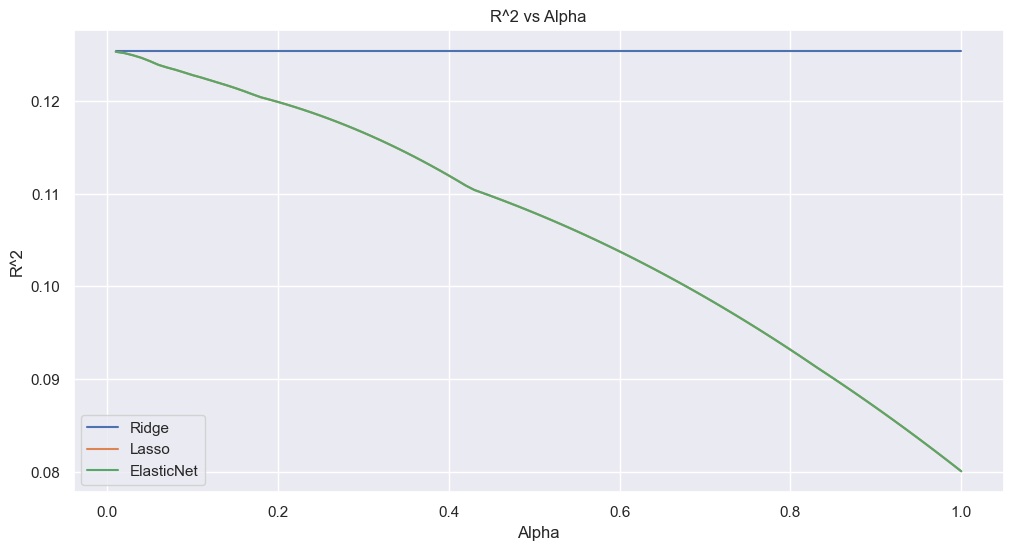

In [53]:
alphas = np.linspace(0.01, 1, 100)
score_ridge = []
score_lasso = []
score_elasticnet = []
for alpha in alphas:
    #print("Alpha:", alpha)
    # Crear modelos de regresión lineal, Lasso y Ridge
    lr = LinearRegression()
    lasso = Lasso(alpha)
    ridge = Ridge(alpha)
    elasticnet = ElasticNet(alpha, l1_ratio=1)

    # Ajustar modelos a los datos
    lr.fit(x, y)
    lasso.fit(x, y)
    ridge.fit(x, y)
    elasticnet.fit(x,y)

    score_ridge.append(ridge.score(x,y))
    score_lasso.append(lasso.score(x,y))
    score_elasticnet.append(elasticnet.score(x,y))

plt.figure(figsize=(12, 6))
plt.plot(alphas, score_ridge, label='Ridge')
plt.plot(alphas, score_lasso, label='Lasso')
plt.plot(alphas, score_elasticnet, label='ElasticNet')
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.legend()
plt.title('R^2 vs Alpha')
plt.show()

Text(0.5, 1.0, 'R^2 vs L1')

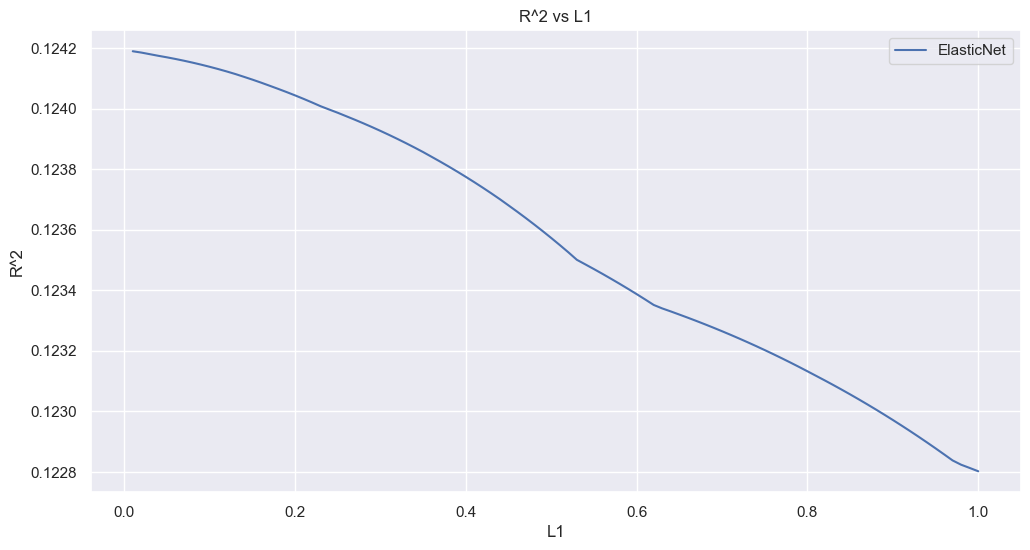

In [54]:
l1=np.linspace(0.01, 1, 100)
score_elasticnet = []
for l in l1:
    # Crear modelos de regresión lineal, Lasso y Ridge
    lr = LinearRegression()
    elasticnet = ElasticNet(alpha=0.1, l1_ratio=l)
    score_elasticnet.append(elasticnet.fit(x,y).score(x,y))

plt.figure(figsize=(12, 6))
plt.plot(l1, score_elasticnet, label='ElasticNet')
plt.xlabel('L1')
plt.ylabel('R^2')
plt.legend()
plt.title('R^2 vs L1')

La mala performance puede deberse, a distintos factores entre los que se encuentran:
- La transformación de los datos no fue la adecuada.
- Los outliers en los datos son mas de los que se esperaba y no se eliminaron correctamente, o inversamente, al eliminar ciertos outliers perdimos información importante.
- La cantidad de datos no es suficiente para entrenar un modelo de regresión lineal.
- La relación entre las variables y la variable target no es lineal.
- La cantidad de variables es muy grande y no todas son relevantes para el modelo.
- La cantidad de variables es muy grande y existe multicolinealidad entre ellas.

Nuestra hipótesis es que un modelo de regresión lineal no es el adecuado para este problema, ya que la relación entre las variables y la variable target no es lineal, esto pudo notarse también al hacer la visualización de los datos, los gráficos presentados podrían haber estado prediciendo este resultado. Por lo tanto, se debería utilizar un modelo de regresión no lineal, como por ejemplo un modelo de regresión polinomial. Se intentara mejorar los resultados en el futuro. 

## Regresión Logística ##

Pretendemos predecir ahora la variable "RainTomorrow" que es una variable categórica. Para esto utilizaremos un modelo de regresión logística. Mostraremos los boxplots según variables para encontrar cuáles de ellas pueden darnos información mas significativa.

In [55]:
columns =   [
                    'MinTemp', 
                    'MaxTemp', 
                    'Evaporation',
                    'Sunshine',
                    'Wind9amu', 
                    'Wind9amv', 
                    'Wind3pmu', 
                    'Wind3pmv', 
                    'WindGustu',
                    'WindGustv', 
                    'Pressure_Difference',
                    'Humidity_Difference'
            ]

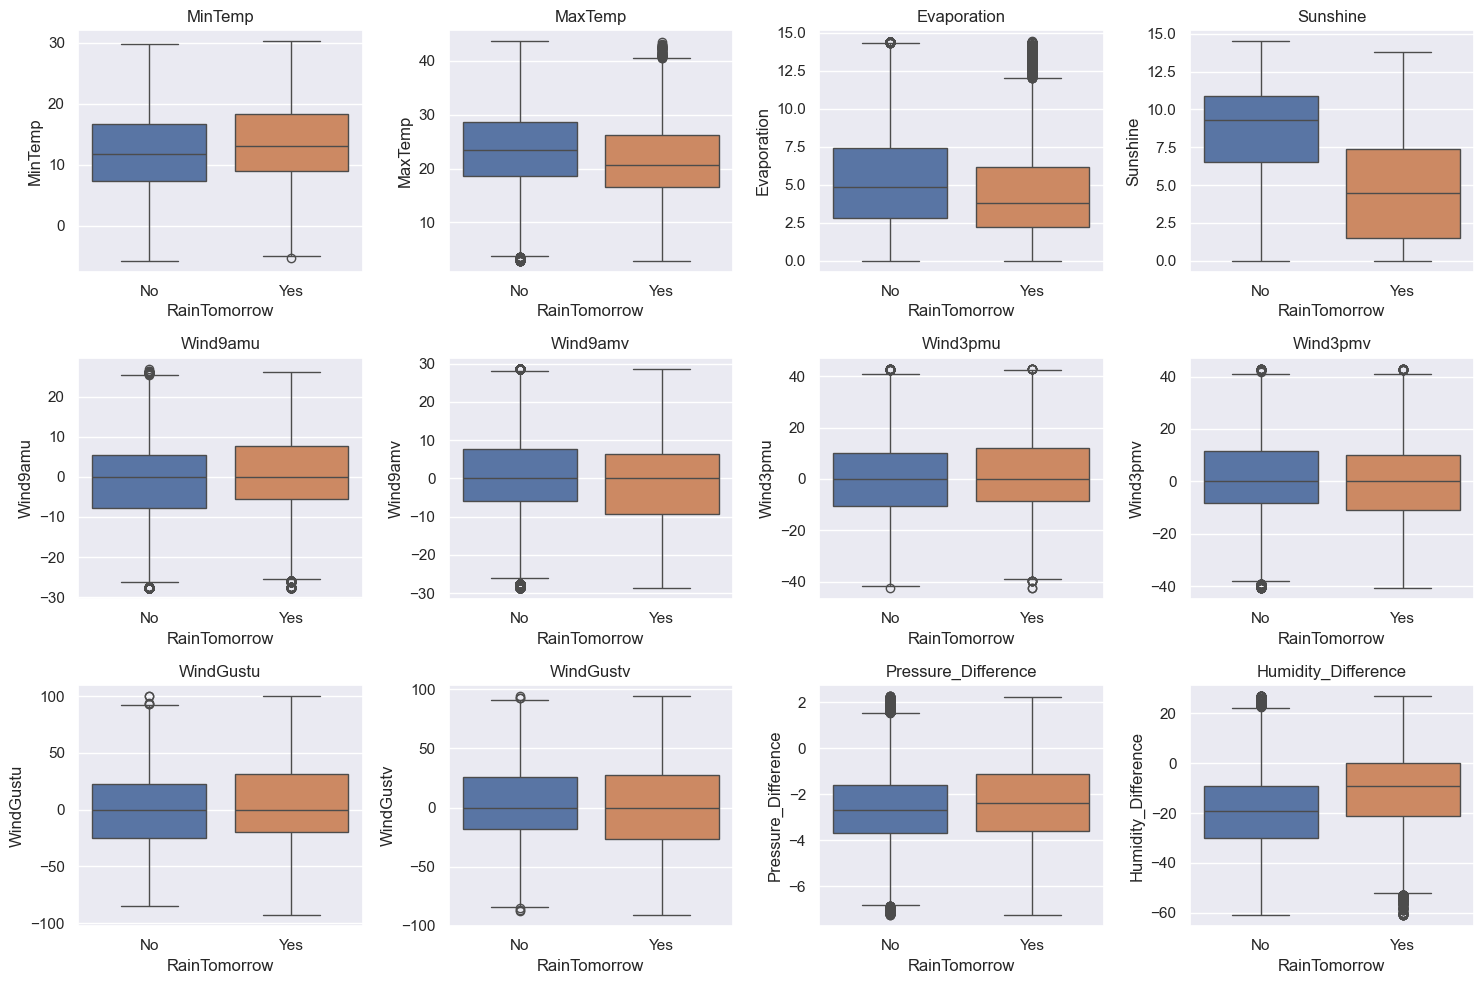

In [56]:
# Crea una figura y subplots
num_rows = 3
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Itera sobre las columnas y crea un gráfico en cada subplot
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    sns.boxplot(data=cleaned_df, x='RainTomorrow', y=column, hue='RainTomorrow', ax=ax)
    ax.set_title(column)

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Vemos que casi todas las variables mantienen una distribución similar para ambos valores de la variable target, excepto para las variables "Sunshine" que presenta una distribución muy distinta para ambos valores de la variable target y en menor medida pero que aún se podría considerar importante, la vairable "Humidity_Difference". Esto nos indica que ambas variables podrían ser muy significativas para nuestro modelo.

In [57]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Humidity_Difference'],'RainTomorrow',0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calcular las métricas de evaluación
print(accuracy_score(y_test, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

          No       0.90      0.76      0.82     18570
         Yes       0.43      0.69      0.53      5056

    accuracy                           0.74     23626
   macro avg       0.67      0.72      0.68     23626
weighted avg       0.80      0.74      0.76     23626

[[14059  4511]
 [ 1588  3468]]
0.7418521967324134


### Resultados de la Clasificación

**Matriz de Confusión:**

- **Verdaderos Positivos (True Positives, TP):** 3577. Son los casos en los que el modelo predijo "Sí" y la respuesta real fue "Sí".

- **Falsos Positivos (False Positives, FP):** 4648. Son los casos en los que el modelo predijo "Sí" pero la respuesta real fue "No".

- **Verdaderos Negativos (True Negatives, TN):** 13990. Son los casos en los que el modelo predijo "No" y la respuesta real fue "No".

- **Falsos Negativos (False Negatives, FN):** 1564. Son los casos en los que el modelo predijo "No" pero la respuesta real fue "Sí".

**Métricas de Evaluación:**

- **Precisión (Precision):** Es la proporción de verdaderos positivos respecto a todos los positivos predichos. En este caso, la precisión para la etiqueta "No" es 0.90 lo que significa que el 90% de las predicciones positivas para "No" son correctas, mientras que para la etiqueta "Yes" es 0.43, lo que significa que el 43% de las predicciones positivas para "Yes" son correctas.

- **Recall:** Es la proporción de verdaderos positivos respecto a todos los verdaderos positivos y falsos negativos. En este caso, el recall es 0.75 para la etiqueta "No" y 0.70 para la etiqueta "Yes" lo que significa que el modelo captura el 75% de todos los casos reales de "No" y el 70% de todos los casos reales de "Yes".

- **F1-score:** Es la media armónica de precisión y recall. En este caso, el F1-score para la etiqueta "Yes" es 0.54 y 0.82 para la etiqueta "No".

- **Exactitud (Accuracy):** Es la proporción de predicciones correctas (verdaderos positivos y verdaderos negativos) respecto al total de muestras. En este caso, la exactitud es 0.74, lo que significa que el 74% de las predicciones son correctas.

En resumen, los resultados indican que el modelo de regresión logística tiene un buen rendimiento en la clasificación de la etiqueta "No" (alta precisión y recall), pero un rendimiento más bajo en la clasificación de la etiqueta "Yes". La exactitud general del modelo es del 74%, lo que sugiere que el modelo es moderadamente bueno en general, pero podría mejorar su capacidad para predecir la etiqueta "Yes". La falta de balance del dataset podría ser un indicador muy fuerte de este resultado.


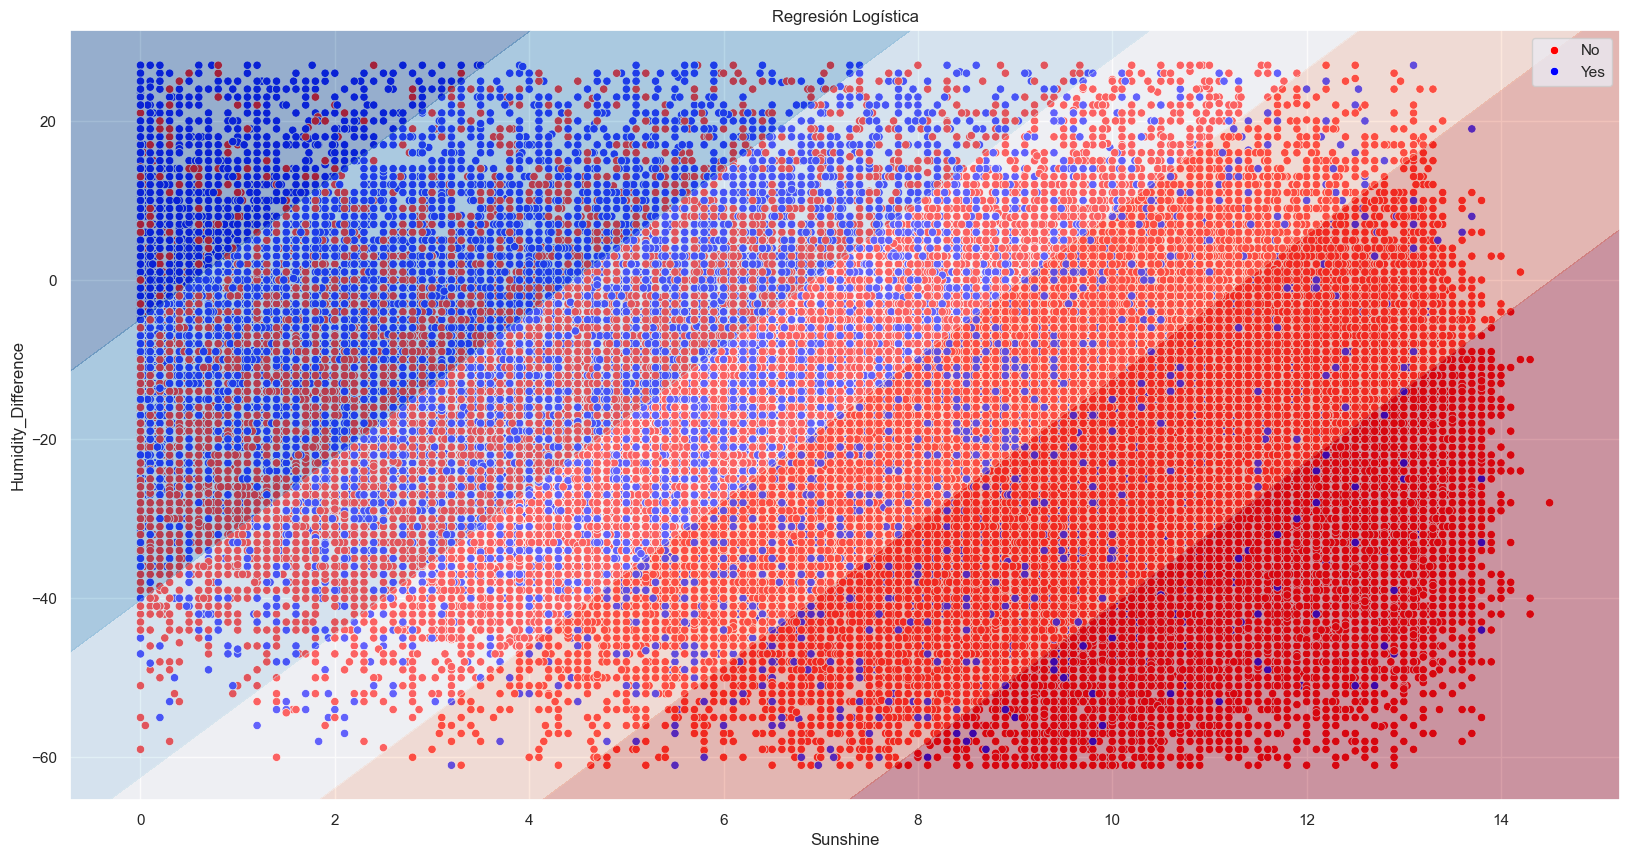

In [58]:
y = [1 if i == "Yes" else 0 for i in y]

# Visualizar los datos y la frontera de decisión del modelo
plt.figure(figsize=(20, 10))

sns.scatterplot(data=cleaned_df, x='Sunshine', y='Humidity_Difference', hue='RainTomorrow', palette=['red', 'blue'], sizes=(50, 200))

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.4)

plt.xlabel('Sunshine')
plt.ylabel('Humidity_Difference')
plt.title('Regresión Logística')
plt.legend()
plt.show()

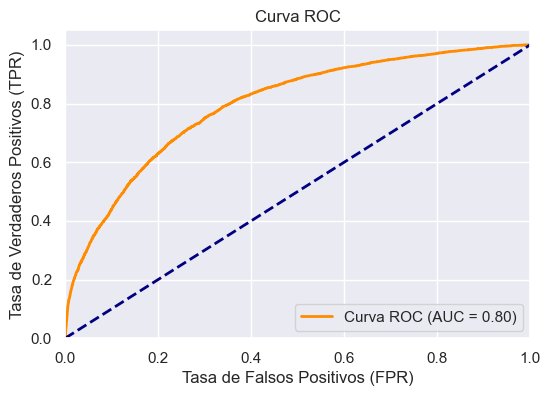

In [59]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Humidity_Difference'],'RainTomorrow',0)
y=[1 if i=="Yes" else 0 for i in y]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Entreno un modelo (en este caso, un clasificador de regresión logística)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Obtengo las probabilidades de predicción del modelo
y_probs = model.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

La **AUC** (Area Under Curve) o Área bajo la Curva nos da en 0.8 lo cuál indica que el modelo tiene un buen rendimiento en la tarea de clasificación binaria.

## Modelos base

### Regresión Logística

Estimaremos la "RainfallTomorrow" usando de métrica únicamente la variable "Evaporation".

[[1.70037847]
 [1.27123984]
 [1.62464812]
 ...
 [1.87708261]
 [1.92756951]
 [1.90232606]]
MSE: 70.6979
R^2: 0.0016


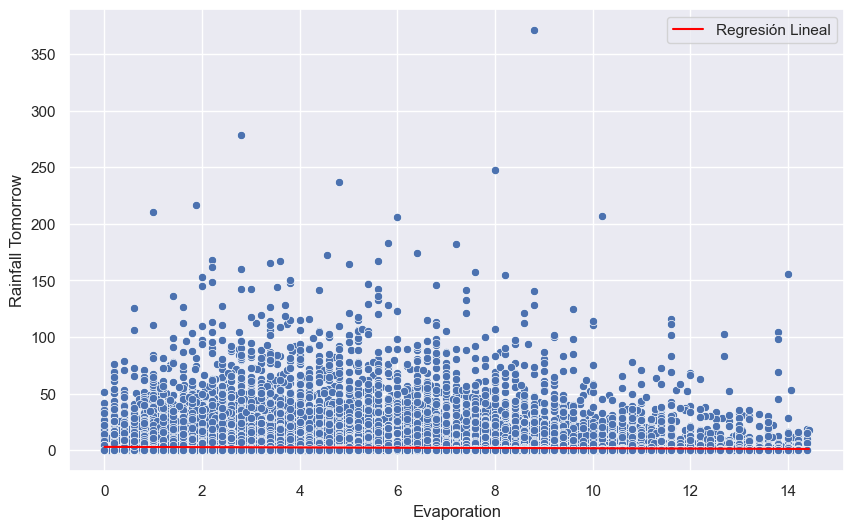

In [78]:
# Seleccionar las características y la variable de destino
x = cleaned_df[['Evaporation']]
y = cleaned_df[['RainfallTomorrow']]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Crear y ajustar un modelo de regresión lineal
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = regression_model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2.item():.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='Evaporation', y='RainfallTomorrow', sizes=(50, 200))
sns.lineplot(x=x['Evaporation'], y=regression_model.predict(x)[:, 0], color='red', label='Regresión Lineal')
plt.xlabel('Evaporation')
plt.ylabel('Rainfall Tomorrow')
plt.show()

### Clasificación

Estimaremos la variable "RainTomorrow" clasificando a todos los valores como el mayor caso, en esta ocasión "No".

In [62]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Humidity_Difference'],'RainTomorrow',0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

y_train = [1 if i == 0 else 0 for i in range(len(y_train))]
y_test = [1 if i == "Yes" else 0 for i in y_test]

# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calcular las métricas de evaluación
print(accuracy_score(y_test, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.77      0.93      0.84     18570
           1       0.02      0.01      0.01      5056

    accuracy                           0.73     23626
   macro avg       0.40      0.47      0.43     23626
weighted avg       0.61      0.73      0.66     23626

[[17206  1364]
 [ 5027    29]]
0.7294929315161263


Ambos modelos tienen resultados muy pobres para sus respectivos casos, sin embargo, dichos resultados nos sirven como punto de partida para comparar con los resultados de los modelos que se entrenarán a continuación. En este caso usaremos dos sistemas de redes neuronales.

## Redes Neuronales

### Regresión

Principalmente no consideraremos una única variable para realizar la predicción, como se hizo en el modelo base, la arquitectura de la red neuronal será la siguiente:

- Capa de entrada: 12 neuronas (1 por cada variable de entrada), función de activación ReLU.
- Capa oculta: 10 neuronas, función de activación ReLU.
- Capa de salida: 1 neurona, función de activación lineal.

In [95]:
columns =   [
                    'MinTemp', 
                    'MaxTemp', 
                    'Evaporation',
                    'Sunshine',
                    'Wind9amu', 
                    'Wind9amv', 
                    'Wind3pmu', 
                    'Wind3pmv', 
                    'WindGustu',
                    'WindGustv', 
                    'Pressure_Difference',
                    'Humidity_Difference'
            ]

x,y=obtención_de_datos(dataframe_normalized(cleaned_df,columns),columns,'RainfallTomorrow')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [115]:
regressionNN = Sequential(
    [
        Dense(12, activation="linear", input_shape=(12,)),
        Dense(15, activation="sigmoid"),
        Dense(15, activation="sigmoid"),
        Dense(1, activation="linear"),
    ]
)

regressionNN.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

history = regressionNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

   1/1108 [..............................] - ETA: 25s

1108/1108 [==============================] - 1s 977us/step
Pérdida final (MSE) - Red Neuronal: 47.9555


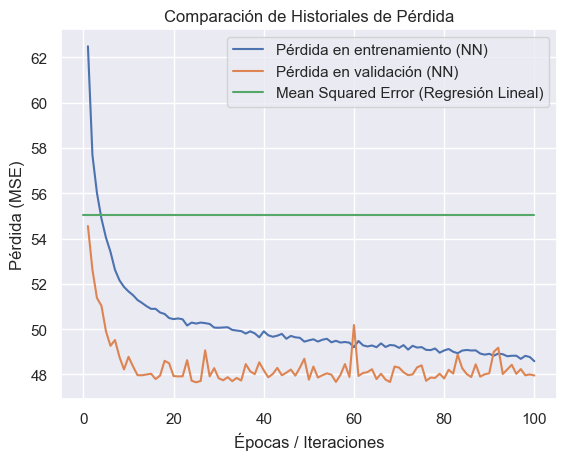

In [119]:
y_pred_nnrg = regressionNN.predict(X_test)

# Calcular la pérdida final
mse_final = mean_squared_error(y_test, y_pred_nnrg)
print(f"Pérdida final (MSE) - Red Neuronal: {mse_final:.4f}")

# Obtener el historial de pérdida
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Graficar el historial de pérdida para la red neuronal
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Pérdida en entrenamiento (NN)')
plt.plot(epochs, val_loss_values, label='Pérdida en validación (NN)')

# Crear un modelo de regresión lineal
lr = LinearRegression(fit_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rg = lr.predict(X_test)

# Calcular el error cuadrático medio para cada predicción
mse_values = [mean_squared_error(y_test, y_pred_rg)]

# Realizar un bucle para ajustar el modelo en cada iteración (no hay realmente iteraciones aquí, pero puedes pensar en ello así)
# y calcular el error cuadrático medio en cada iteración
for epoch in range(100):  # Puedes ajustar el número de "épocas" según tus necesidades
    # Ajustar el modelo (aunque en este caso no hay realmente un ajuste iterativo)
    lr.fit(X_train, y_train)
    
    # Realizar predicciones
    y_pred_rg = lr.predict(X_test)
    
    # Calcular el error cuadrático medio y agregarlo a la lista
    mse_values.append(mean_squared_error(y_test, y_pred_rg))

# Graficar el historial de pérdida para la regresión lineal
plt.plot(np.arange(len(mse_values)), mse_values, label='Mean Squared Error (Regresión Lineal)')

# Configurar la visualización
plt.xlabel('Épocas / Iteraciones')  
plt.ylabel('Pérdida (MSE)')
plt.title('Comparación de Historiales de Pérdida')
plt.legend()
plt.show()

### Clasificación

Usaremos las mismas variables para la clasificación que el modelo base, la arquitectura de la red neuronal será la siguiente:

- Capa de entrada: 2 neuronas (1 por cada variable de entrada), función de activación Linear.
- 2 Capas ocultas: 5 neuronas, función de activación ReLU.
- Capa de salida: 1 neurona, función de activación sigmoidea.

In [143]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Humidity_Difference'],'RainTomorrow',0)
y = np.array([1 if i == "Yes" else 0 for i in y])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [ ]:
clasificadorNN = Sequential(
    [
        Dense(2, activation="linear", input_shape=(2,)),
        Dense(5, activation="relu"),
        Dense(5, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

clasificadorNN.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mean_squared_error"])

history = clasificadorNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [152]:
y_pred = clasificadorNN.predict(X_test)
y_pred_nnc = [1 if i >= 0.5 else 0 for i in y_pred]
print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred_nnc))
print(confusion_matrix(y_test, y_pred_nnc))

# Calcular las métricas de evaluación
print(accuracy_score(y_test, y_pred_nnc))

  1/739 [..............................] - ETA: 11s

739/739 [==============================] - 1s 949us/step
Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     18570
           1       0.67      0.30      0.41      5056

    accuracy                           0.82     23626
   macro avg       0.75      0.63      0.65     23626
weighted avg       0.80      0.82      0.79     23626

[[17843   727]
 [ 3555  1501]]
0.8187589943282824
